### Goal for Scenario #1:



Your task is as follows:
1. Calculate the yearly liquor sales for each store using the provided data. You can add up the transactions for each year, and store sales in 2015 specifically will be used later as your target variable.
2. Use the data from 2015 to make a linear model using as many variables as you find useful to predict the yearly sales of each store. You must use the sales from Jan to March per store as one of your variables.
3. Use your model for 2015 to estimate total sales for each store in 2016, extrapolating from the sales so far for Jan-March of 2016.
4. Report your findings, including any projected increase or decrease in total sales (over the entire state) for the tax committee of the Iowa legislature.
5. Use cross-validation to check how your model predicts to held out data compared to the model metrics on the full dataset.

6. Challenging Bonus: We did not cover the topics of regularization for linear regression this week, but those feeling bold can try to use and understand regularizing linear regressions. This will require self-guided research/reading and scikit-learn functions that we have not gone over in class! Use cross-validation to tune the regularization parameter that maximizes R^2 on your holdout sets for the Ridge regression and the Lasso Regression. Do the regularized models perform better than the non-regularized model? Which regularized model performs better? What is the Ridge regression doing? What is the Lasso doing.


In [1076]:
# Importing packages
import pandas as pd
import numpy as np
import matplotlib as matp
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn import metrics


from string import letters
import statsmodels.formula.api as smf
import datetime
from scrapy.selector import Selector
from scrapy.http import HtmlResponse



%matplotlib inline

In [61]:
# Load the data
iowa_df = pd.read_csv("Iowa_Liquor_sales_sample_10pct.csv") 
print iowa_df.columns
print iowa_df.shape
iowa_df.head(2)

Index([u'Date', u'Store Number', u'City', u'Zip Code', u'County Number',
       u'County', u'Category', u'Category Name', u'Vendor Number',
       u'Item Number', u'Item Description', u'Bottle Volume (ml)',
       u'State Bottle Cost', u'State Bottle Retail', u'Bottles Sold',
       u'Sale (Dollars)', u'Volume Sold (Liters)', u'Volume Sold (Gallons)'],
      dtype='object')
(270955, 18)


,Date,Store Number,City,Zip Code,County Number,County,Category,Category Name,Vendor Number,Item Number,Item Description,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons)
0,11/04/2015,3717,SUMNER,50674,9.0,Bremer,1051100.0,APRICOT BRANDIES,55,54436,Mr. Boston Apricot Brandy,750,$4.50,$6.75,12,$81.00,9.0,2.38
1,03/02/2016,2614,DAVENPORT,52807,82.0,Scott,1011100.0,BLENDED WHISKIES,395,27605,Tin Cup,750,$13.75,$20.63,2,$41.26,1.5,0.40


In [873]:
iowa_df.tail(2)

,date,store_num,city,zip_code,county_number,county,category,category_name,vendor_number,item_number,item_description,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,year,month
270953,2015-11-20,3562,WEST BURLINGTON,52655,29.0,Des Moines,1082900.0,MISC. IMPORTED CORDIALS & LIQUEURS,192,65258,Jagermeister Liqueur,1750,26.05,39.08,6,234.48,10.5,2015,11
270954,2015-01-27,4446,URBANDALE,50322,77.0,Polk,1031080.0,VODKA 80 PROOF,260,37993,Smirnoff Vodka 80 Prf,200,2.75,4.13,8,33.04,1.6,2015,1


In [63]:
iowa_df.describe()

,Store Number,County Number,Category,Vendor Number,Item Number,Bottle Volume (ml),Bottles Sold,Volume Sold (Liters),Volume Sold (Gallons)
count,270955.000000,269878.000000,2.708870e+05,270955.00000,270955.000000,270955.000000,270955.000000,270955.000000,270955.000000
mean,3590.263701,57.231642,1.043888e+06,256.43443,45974.963300,924.830341,9.871285,8.981351,2.372830
std,947.662050,27.341205,5.018211e+04,141.01489,52757.043086,493.088489,24.040912,28.913690,7.638182
min,2106.000000,1.000000,1.011100e+06,10.00000,168.000000,50.000000,1.000000,0.100000,0.030000
25%,2604.000000,31.000000,1.012200e+06,115.00000,26827.000000,750.000000,2.000000,1.500000,0.400000
50%,3722.000000,62.000000,1.031200e+06,260.00000,38176.000000,750.000000,6.000000,5.250000,1.390000
75%,4378.000000,77.000000,1.062310e+06,380.00000,64573.000000,1000.000000,12.000000,10.500000,2.770000
max,9023.000000,99.000000,1.701100e+06,978.00000,995507.000000,6000.000000,2508.000000,2508.000000,662.540000


## Cleaning the data

In [64]:
# Remove redundant columns
## Removing Volume Sold (Gallons)
del iowa_df['Volume Sold (Gallons)']
iowa_df.head(0)

,Date,Store Number,City,Zip Code,County Number,County,Category,Category Name,Vendor Number,Item Number,Item Description,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters)


In [65]:
## Renaming variables
## Doing it one at a time
iowa_df.rename(columns= 
{"Store Number" : 'store_num', "Zip Code": 'zip_code', 'County Number': 'county_number'}, inplace=True)

## Making all the columns be lower case and removing spaces 
iowa_df.columns = [ x.lower() for x in iowa_df.columns ]
iowa_df.columns = [ x.replace(' ', '_') for x in iowa_df.columns ]
iowa_df.columns = [ x.replace("(", "") for x in iowa_df.columns]
iowa_df.columns = [ x.replace(")", "") for x in iowa_df.columns]
iowa_df.head(0)

,date,store_num,city,zip_code,county_number,county,category,category_name,vendor_number,item_number,item_description,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters


In [66]:
# Remove $ from certain columns, and casting them to floats
clean_sign = ['state_bottle_cost', 'state_bottle_retail', 'sale_dollars']
for i in clean_sign:
    iowa_df[i] = map(lambda x:float(x.replace('$','')), iowa_df[i])
iowa_df.head(2)

,date,store_num,city,zip_code,county_number,county,category,category_name,vendor_number,item_number,item_description,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters
0,11/04/2015,3717,SUMNER,50674,9.0,Bremer,1051100.0,APRICOT BRANDIES,55,54436,Mr. Boston Apricot Brandy,750,4.50,6.75,12,81.00,9.0
1,03/02/2016,2614,DAVENPORT,52807,82.0,Scott,1011100.0,BLENDED WHISKIES,395,27605,Tin Cup,750,13.75,20.63,2,41.26,1.5


In [67]:
## Convert dates and creating month and year columns
iowa_df['date'] = pd.to_datetime(iowa_df['date'])
iowa_df['year'] = iowa_df.date.dt.year
iowa_df['month'] =iowa_df.date.dt.month
iowa_df.info()
iowa_df.year.value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270955 entries, 0 to 270954
Data columns (total 19 columns):
date                   270955 non-null datetime64[ns]
store_num              270955 non-null int64
city                   270955 non-null object
zip_code               270955 non-null object
county_number          269878 non-null float64
county                 269878 non-null object
category               270887 non-null float64
category_name          270323 non-null object
vendor_number          270955 non-null int64
item_number            270955 non-null int64
item_description       270955 non-null object
bottle_volume_ml       270955 non-null int64
state_bottle_cost      270955 non-null float64
state_bottle_retail    270955 non-null float64
bottles_sold           270955 non-null int64
sale_dollars           270955 non-null float64
volume_sold_liters     270955 non-null float64
year                   270955 non-null int64
month                  270955 non-null int64
dtypes: 

2015    218594
2016     52361
Name: year, dtype: int64

In [8]:
iowa_df.isnull().any() ## Finding columns with missing observations

date                   False
store_num              False
city                   False
zip_code               False
county_number           True
county                  True
category                True
category_name           True
vendor_number          False
item_number            False
item_description       False
bottle_volume_ml       False
state_bottle_cost      False
state_bottle_retail    False
bottles_sold           False
sale_dollars           False
volume_sold_liters     False
year                   False
month                  False
dtype: bool

In [875]:
## Searching for missing values
# County number
bad_county_number = [ (i,x) 
                      for i,x in enumerate(iowa_df.county_number) 
                      if pd.isnull(x) 
                    ]
print len(bad_county_number)

# County
bad_county = [ (i,x) 
                for i,x in enumerate(iowa_df.county) 
                if pd.isnull(x) 
                    ]
print len(bad_county)

# Category              
bad_category = [ (i,x) 
                for i,x in enumerate(iowa_df.category) 
                if pd.isnull(x) 
                    ]
print len(bad_category)

# category_name         
bad_category_name = [ (i,x)
                    for i,x in enumerate(iowa_df.category_name)
                    if pd.isnull(x)
                    ]
print len(bad_category_name)

# print bad_county_number

1077
1077
68
632


In [303]:
## Droppping missing observations
print "Shape of Original Data", iowa_df.shape

mask_drop = ( iowa_df.county.isnull() | iowa_df.county_number.isnull() 
       | iowa_df.category.isnull () | iowa_df.category_name.isnull())

iowa_clean = iowa_df[~mask_drop]
iowa_clean.shape

Shape of Original Data (270955, 19)


(269258, 19)

In [278]:
## Checking for missing values again
iowa_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 269258 entries, 0 to 270954
Data columns (total 19 columns):
date                   269258 non-null datetime64[ns]
store_num              269258 non-null int64
city                   269258 non-null object
zip_code               269258 non-null object
county_number          269258 non-null float64
county                 269258 non-null object
category               269258 non-null float64
category_name          269258 non-null object
vendor_number          269258 non-null int64
item_number            269258 non-null int64
item_description       269258 non-null object
bottle_volume_ml       269258 non-null int64
state_bottle_cost      269258 non-null float64
state_bottle_retail    269258 non-null float64
bottles_sold           269258 non-null int64
sale_dollars           269258 non-null float64
volume_sold_liters     269258 non-null float64
year                   269258 non-null int64
month                  269258 non-null int64
dtypes: 

In [16]:
## County should be integer
iowa_clean['county_number'] = map(lambda x:int(x), iowa_clean['county_number'])
# iowa_clean.county_number = iowa_clean.county_number.astype(int)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [17]:
iowa_clean.head(2)

,date,store_num,city,zip_code,county_number,county,category,category_name,vendor_number,item_number,item_description,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,year,month
0,2015-11-04,3717,SUMNER,50674,9,Bremer,1051100.0,APRICOT BRANDIES,55,54436,Mr. Boston Apricot Brandy,750,4.50,6.75,12,81.00,9.0,2015,11
1,2016-03-02,2614,DAVENPORT,52807,82,Scott,1011100.0,BLENDED WHISKIES,395,27605,Tin Cup,750,13.75,20.63,2,41.26,1.5,2016,3


# Explore the data 

Perform some exploratory statistical analysis and make some plots, such as histograms of transaction totals, bottles sold, etc.

In [319]:
## For furthere analysis I am creating a profit column
iowa_clean['profit'] = (iowa_clean['state_bottle_retail']- iowa_clean['state_bottle_cost']) * iowa_clean['bottles_sold']
iowa_clean.head(2)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,date,store_num,city,zip_code,county_number,county,category,category_name,vendor_number,item_number,item_description,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,year,month,profit
0,2015-11-04,3717,SUMNER,50674,9.0,Bremer,1051100.0,APRICOT BRANDIES,55,54436,Mr. Boston Apricot Brandy,750,4.50,6.75,12,81.00,9.0,2015,11,27.00
1,2016-03-02,2614,DAVENPORT,52807,82.0,Scott,1011100.0,BLENDED WHISKIES,395,27605,Tin Cup,750,13.75,20.63,2,41.26,1.5,2016,3,13.76


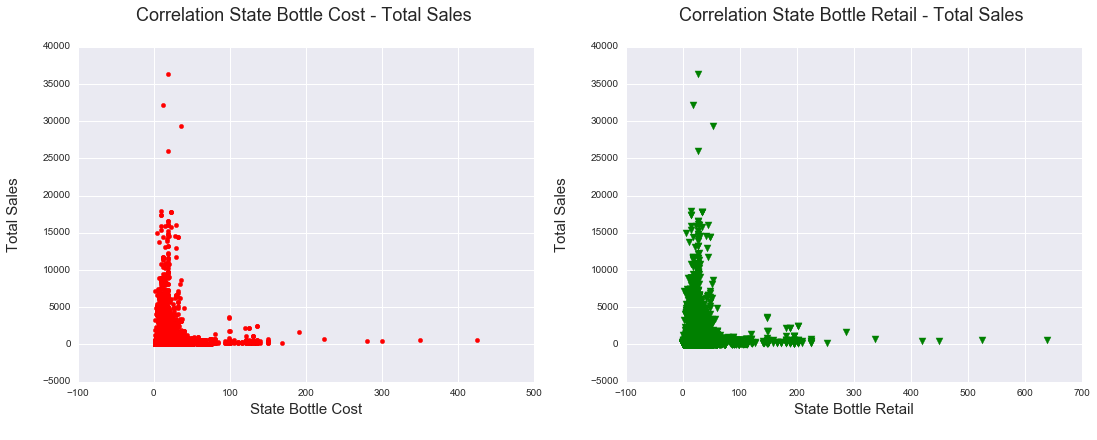

In [19]:
## Scatter plots
fig = plt.figure(figsize=(18,6))
# ## Bottle Cost and Sales
ax1 = plt.subplot(1,2,1)
plt.scatter(iowa_clean['state_bottle_cost'], iowa_clean['sale_dollars'], color ='red')
plt.title('Correlation State Bottle Cost - Total Sales \n', fontsize =18)
plt.ylabel("Total Sales\n", fontsize = 15)
plt.xlabel("State Bottle Cost\n", fontsize = 15)

# ## Bottle Retail and Sales
ax2 = plt.subplot(1,2,2)
plt.scatter(iowa_clean['state_bottle_retail'], iowa_clean['sale_dollars'], marker='v', color='green', s= 50)
plt.title('Correlation State Bottle Retail - Total Sales \n', fontsize =18)
plt.ylabel("Total Sales\n", fontsize = 15)
plt.xlabel("State Bottle Retail", fontsize = 15)


plt.show()

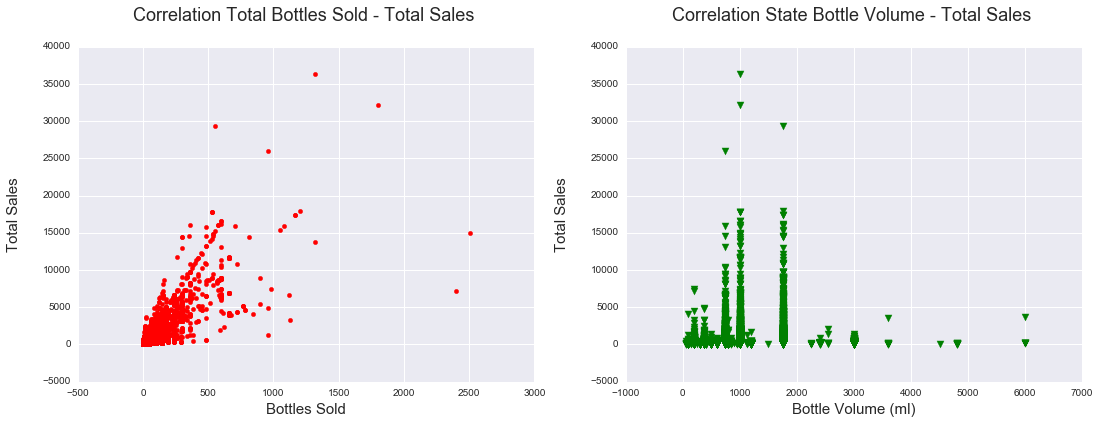

In [20]:
## Scatter Plots
fig = plt.figure(figsize=(18,6))

# ## Bottles Sold and Sales
ax1 = plt.subplot(1,2,1)
plt.scatter(iowa_clean['bottles_sold'], iowa_clean['sale_dollars'], color ='red')
plt.title('Correlation Total Bottles Sold - Total Sales \n', fontsize =18)
plt.ylabel("Total Sales\n", fontsize = 15)
plt.xlabel("Bottles Sold\n", fontsize = 15)

# ## Bottle Volume Sold and Sales
ax2 = plt.subplot(1,2,2)
plt.scatter(iowa_clean['bottle_volume_ml'], iowa_clean['sale_dollars'], marker='v', color='green', s= 50)
plt.title('Correlation State Bottle Volume - Total Sales \n', fontsize =18)
plt.ylabel("Total Sales\n", fontsize = 15)
plt.xlabel("Bottle Volume (ml)", fontsize = 15)


plt.show()

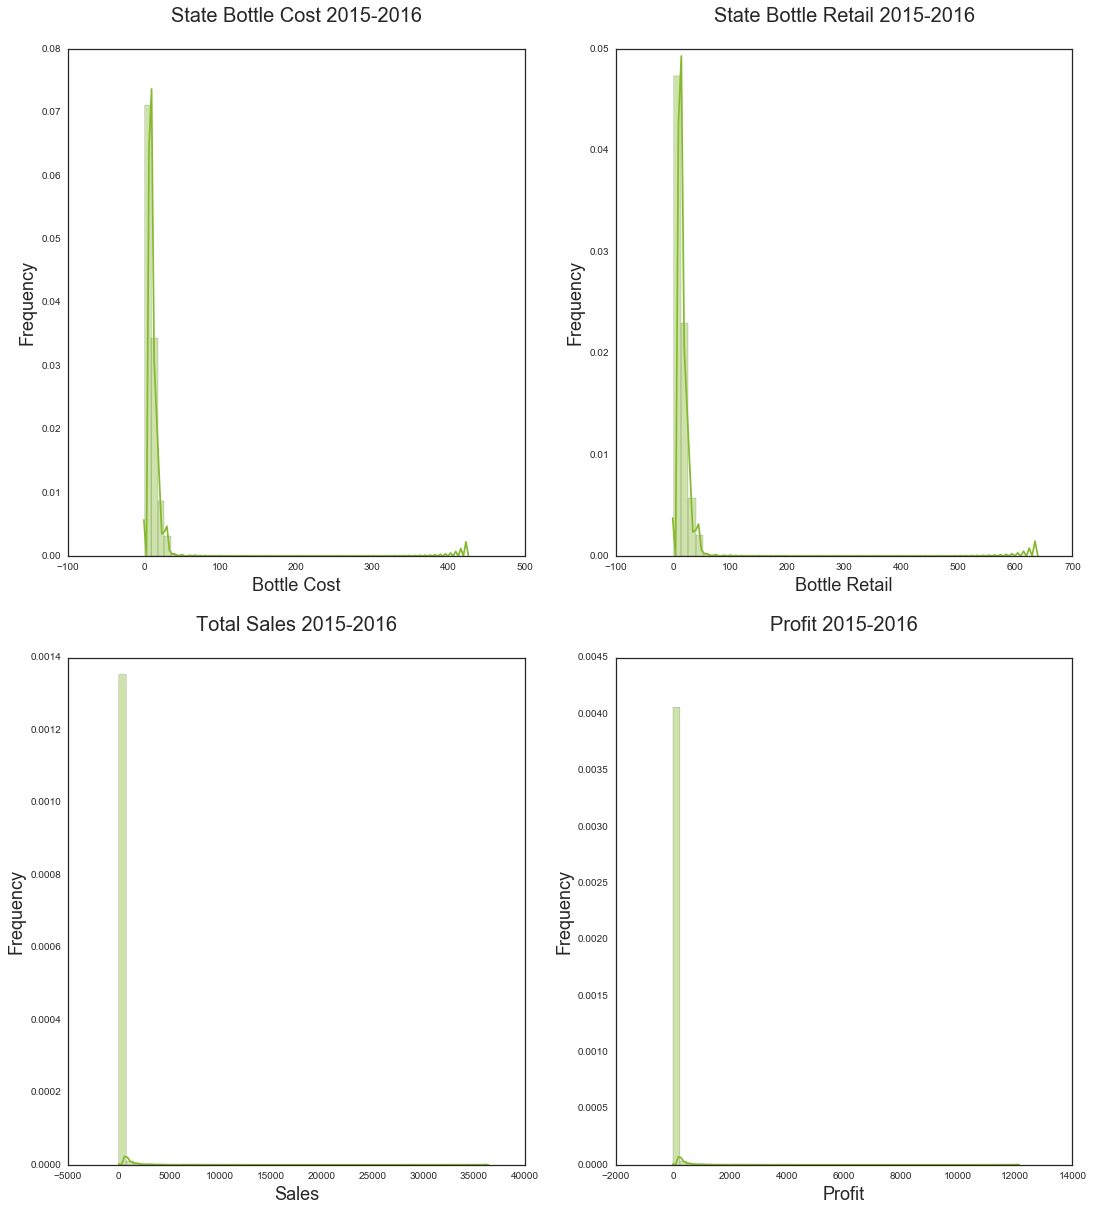

In [21]:
## Histograms
fig = plt.figure(figsize=(18,20))
# # Set the Seaborn style
sns.set_style('white')
# # Specify a color for plotting
current_palette = matp.colors.hex2color('#86b92e')

## State Bottle Cost
ax1 = plt.subplot(2,2,1)
ax = sns.distplot(iowa_clean.state_bottle_cost, kde=True, norm_hist = False, color=current_palette)
sns.plt.title('State Bottle Cost 2015-2016\n', fontsize = 20)
plt.xlabel('Bottle Cost', fontsize=18)
plt.ylabel('Frequency', fontsize=18)

## State Bottle Retail
ax2 = plt.subplot(2,2,2)
ax = sns.distplot(iowa_clean.state_bottle_retail, kde=True, norm_hist = False, color=current_palette)
sns.plt.title('State Bottle Retail 2015-2016\n', fontsize = 20)
plt.xlabel('Bottle Retail', fontsize=18)
plt.ylabel('Frequency', fontsize=18)

## Sales
ax2 = plt.subplot(2,2,3)
ax = sns.distplot(iowa_clean.sale_dollars, kde=True, norm_hist = False, color=current_palette)
sns.plt.title('Total Sales 2015-2016\n', fontsize = 20)
plt.xlabel('Sales', fontsize=18)
plt.ylabel('Frequency', fontsize=18)

## Profit
ax2 = plt.subplot(2,2,4)
ax = sns.distplot(iowa_clean.profit, kde=True, norm_hist = False, color=current_palette)
sns.plt.title('Profit 2015-2016\n', fontsize = 20)
plt.xlabel('Profit', fontsize=18)
plt.ylabel('Frequency', fontsize=18)


plt.show()

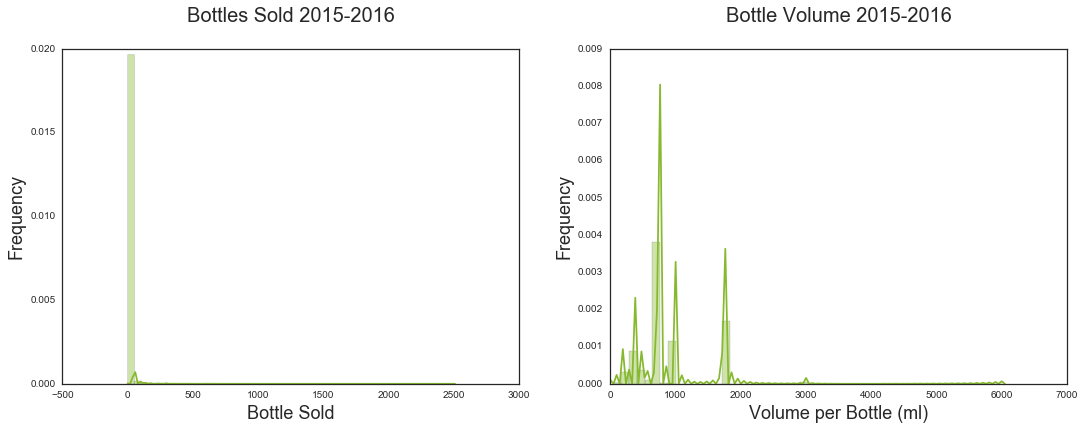

In [22]:
## Histograms
fig = plt.figure(figsize=(18,6))
## Bottles Sold
ax2 = plt.subplot(1,2,1)
ax = sns.distplot(iowa_clean.bottles_sold, kde=True, norm_hist = False, color=current_palette)
sns.plt.title('Bottles Sold 2015-2016\n', fontsize = 20)
plt.xlabel('Bottle Sold', fontsize=18)
plt.ylabel('Frequency', fontsize=18)

## Bottles Volume
ax2 = plt.subplot(1,2,2)
ax = sns.distplot(iowa_clean.bottle_volume_ml, kde=True, norm_hist = False, color=current_palette)
sns.plt.title('Bottle Volume 2015-2016\n', fontsize = 20)
plt.xlabel('Volume per Bottle (ml)', fontsize=18)
plt.ylabel('Frequency', fontsize=18)

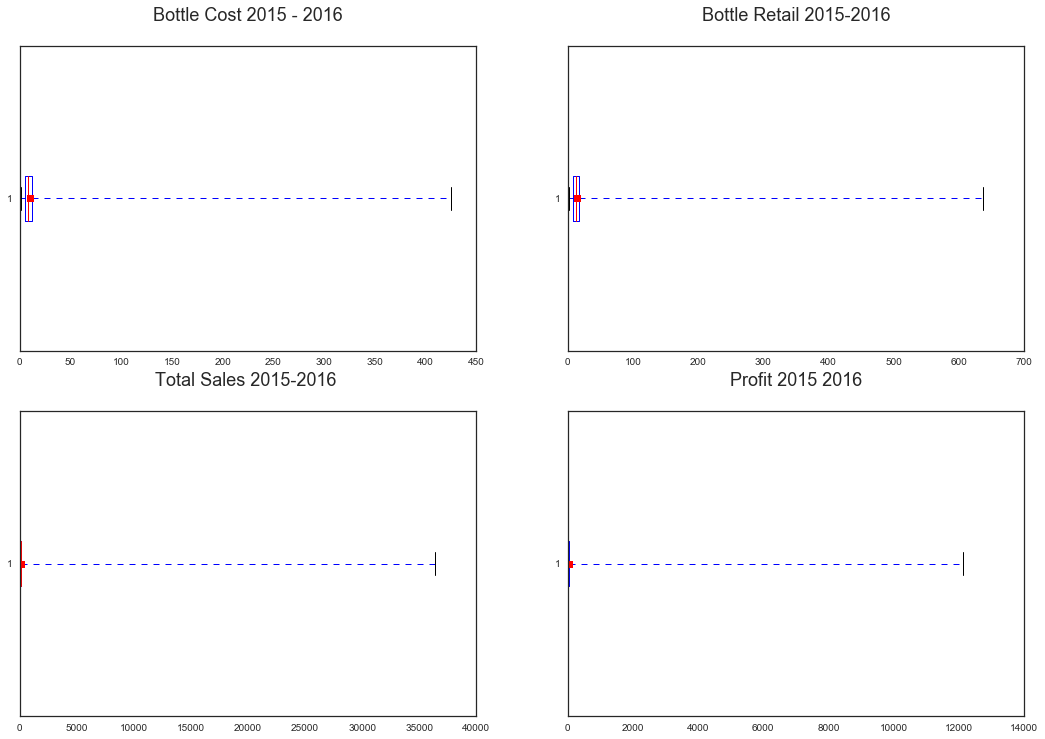

In [23]:
## Box Plots
fig = plt.figure(figsize=(18,12))

# ## Bottle Cost
ax1 = plt.subplot(2,2,1)
plt.boxplot(iowa_clean.state_bottle_cost, 0,'rs', 0, 500, showmeans=True)
plt.title('Bottle Cost 2015 - 2016\n', fontsize = 18)

# ## Bottle Retail
ax1 = plt.subplot(2,2,2)
plt.boxplot(iowa_clean.state_bottle_retail, 0,'rs', 0, 500, showmeans=True)
plt.title('Bottle Retail 2015-2016\n', fontsize = 18)

# ## Sales
ax1 = plt.subplot(2,2,3)
plt.boxplot(iowa_clean.sale_dollars, 0,'rs', 0, 500, showmeans=True)
plt.title('Total Sales 2015-2016 \n', fontsize = 18)

# ## Profit
ax1 = plt.subplot(2,2,4)
plt.boxplot(iowa_clean.profit, 0,'rs', 0, 500, showmeans=True)
plt.title('Profit 2015 2016\n', fontsize = 18)
plt.show()

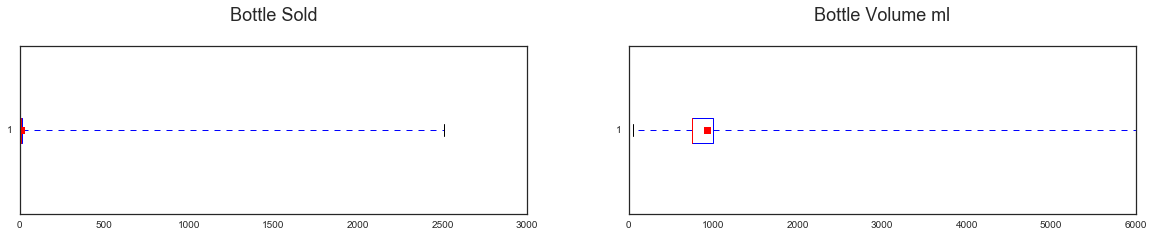

In [24]:
## Box Plots
fig = plt.figure(figsize=(20,3))

# ## Bottle Sold
ax1 = plt.subplot(1,2,1)
plt.boxplot(iowa_clean.bottles_sold, 0,'rs', 0, 500, showmeans=True)
plt.title('Bottle Sold\n', fontsize = 18)

# ## Bottle Volume
ax1 = plt.subplot(1,2,2)
plt.boxplot(iowa_clean.bottle_volume_ml, 0,'rs', 0, 500, showmeans=True)
plt.title('Bottle Volume ml\n', fontsize = 18)
plt.show()

In [256]:
# First and last sales date.
print "First sales date:", iowa_clean.date.min()
print "Last sales date:", iowa_clean.date.max()

## Number of unique entries per column
num_unique_stores = len(iowa_clean.store_num.unique())
print "Number of unique stores is: ", num_unique_stores

num_unique_counties = len(iowa_clean.county_number.unique())
print "Number of unique counties is: ", num_unique_counties

num_unique_cities = len(iowa_clean.city.unique())
print "Number of unique cities is: ", num_unique_cities

num_unique_zipcode = len(iowa_clean.zip_code.unique())
print "Number of unique zip codes is: ", num_unique_zipcode

num_unique_cat_name = len(iowa_clean.category_name.unique())
print "Number of unique alcohol category is: ", num_unique_cat_name

num_unique_item_des = len(iowa_clean.item_description.unique())
print "Number of unique liquor brands is: ", num_unique_item_des

num_unique_ven_num = len(iowa_clean.vendor_number.unique())
print "Number of unique vendor number: ", num_unique_ven_num

# print "Lenght of store number list", len(iowa_clean.store_num)

First sales date: 2015-01-05 00:00:00
Last sales date: 2016-03-31 00:00:00
Number of unique stores is:  1378
Number of unique counties is:  99
Number of unique cities is:  382
Number of unique zip codes is:  412
Number of unique alcohol category is:  71
Number of unique liquor brands is:  2158
Number of unique vendor number:  115


In [ ]:
## Graph Sublist using 
sub_list = iowa_clean[['state_bottle_cost', 'state_bottle_retail','bottle_volume_ml','bottles_sold', 'sale_dollars', 'profit']]
sub_list.head(4)

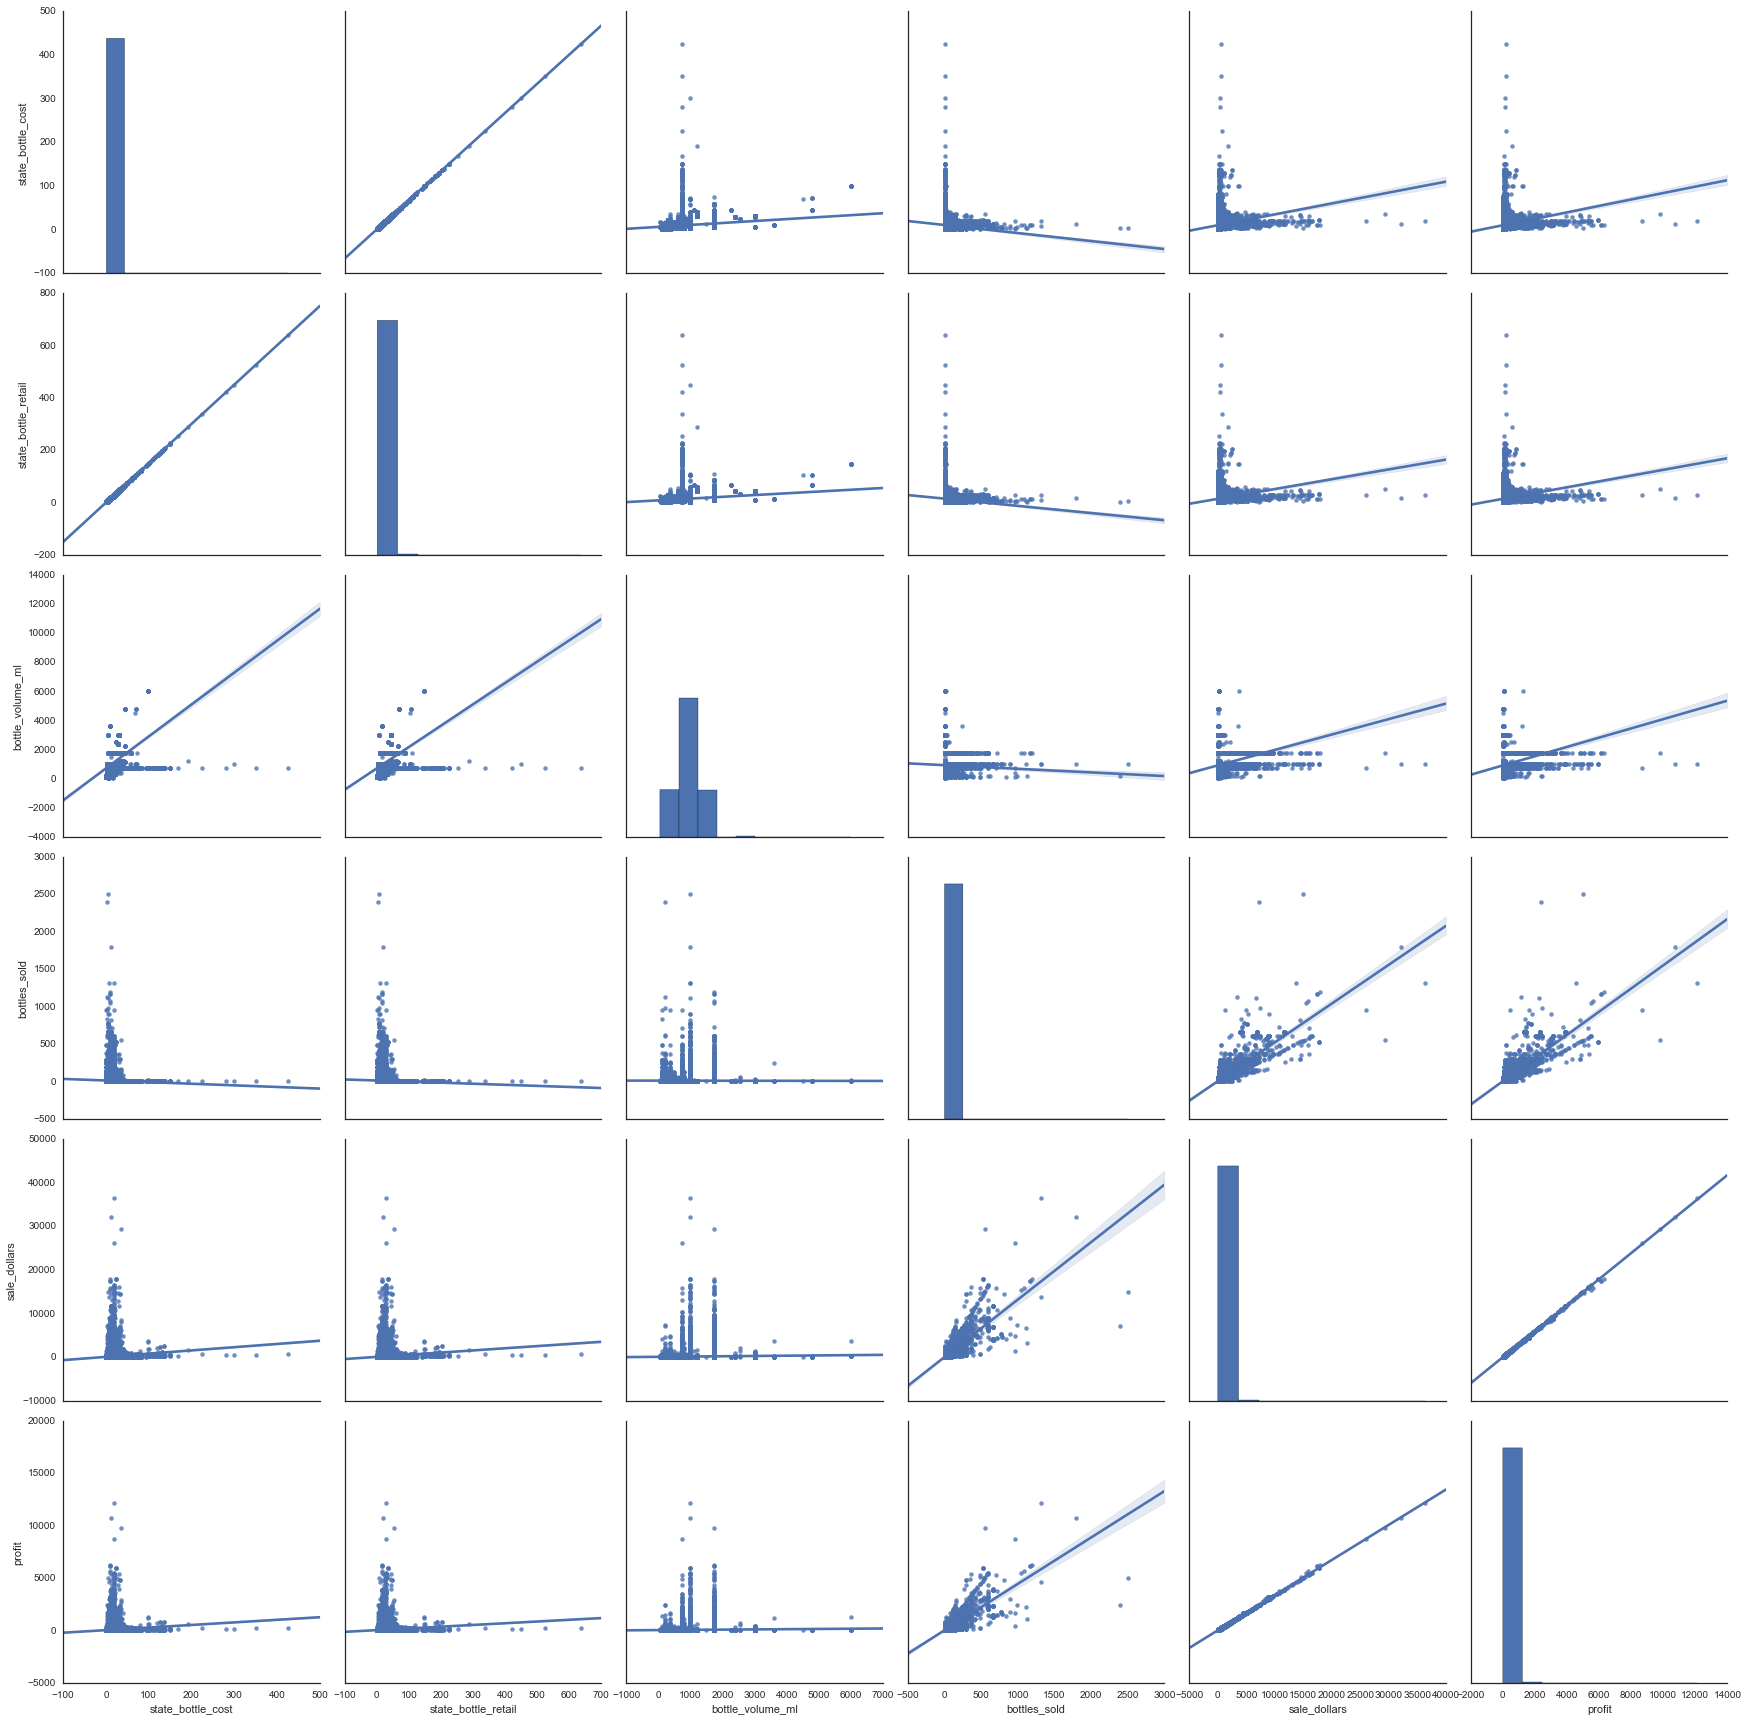

In [197]:
## Graph Sublist using SNS (takes forever)
sns.pairplot(sub_list,size=4, kind="reg")

In [28]:
## Describing the sublist
sub_list.describe()

,state_bottle_cost,state_bottle_retail,bottle_volume_ml,bottles_sold,sale_dollars,profit
count,269258.000000,269258.000000,269258.000000,269258.000000,269258.000000,269258.000000
mean,9.763293,14.660848,925.217375,9.874028,128.828546,43.073277
std,7.039787,10.559164,492.837459,24.072335,383.477046,128.751092
min,0.890000,1.340000,50.000000,1.000000,1.340000,0.000000
25%,5.500000,8.250000,750.000000,2.000000,30.420000,10.150000
50%,8.000000,12.110000,750.000000,6.000000,70.560000,23.520000
75%,11.920000,17.880000,1000.000000,12.000000,135.000000,45.000000
max,425.000000,637.500000,6000.000000,2508.000000,36392.400000,12130.800000


In [29]:
## Correlation
sub_list.corr()

,state_bottle_cost,state_bottle_retail,bottle_volume_ml,bottles_sold,sale_dollars,profit
state_bottle_cost,1.000000,0.999960,0.312930,-0.062832,0.135770,0.134701
state_bottle_retail,0.999960,1.000000,0.313911,-0.062684,0.135954,0.134927
bottle_volume_ml,0.312930,0.313911,1.000000,-0.012183,0.082553,0.082977
bottles_sold,-0.062832,-0.062684,-0.012183,1.000000,0.825912,0.827511
sale_dollars,0.135770,0.135954,0.082553,0.825912,1.000000,0.999799
profit,0.134701,0.134927,0.082977,0.827511,0.999799,1.000000


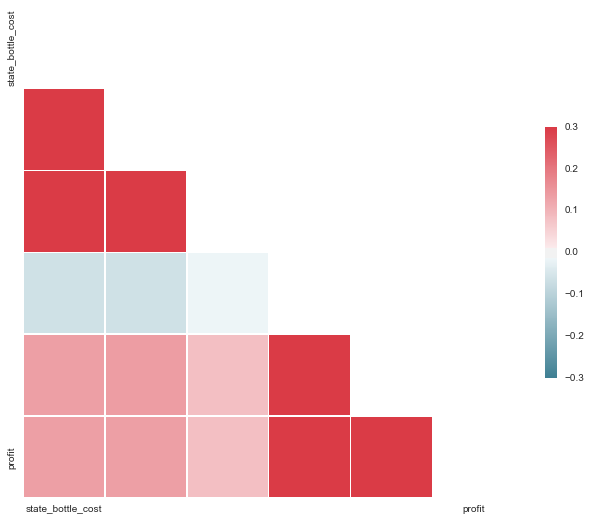

In [46]:
# Correlation Graph
corr = sub_list.corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True, xticklabels=5, yticklabels=5,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

In [72]:
## Grouping by city and zip code
group_city_zip = iowa_clean.groupby(['city', 'zip_code']).size()
group_city_zip
# As I expected some zip codes dont have city names, and some names don't have the correct or updated Zip Code
# Be careful in the analysis

city             zip_code
ACKLEY           50601         91
ADAIR            50002         43
ADEL             50003        318
AFTON            50830         12
AKRON            51001         69
ALBIA            52531        341
ALDEN            50006        122
ALGONA           50511       1025
ALLISON          50602         83
ALTA             51002         14
ALTOONA          50009       2103
AMES             50010       7077
                 50014        457
ANAMOSA          52205        583
ANITA            50020        148
ANKENY           50021       2521
                 50023       2302
ANTHON           51004        164
ARLINGTON        50606         76
ARMSTRONG        50514         17
ARNOLD'S PARK    51331        242
ARNOLDS PARK     51331        497
ATLANTIC         50022       1037
AUDUBON          50025        205
AURELIA          51005         11
AVOCA            51521        457
BALDWIN          52207         26
BANCROFT         50517        371
BAXTER           50028

In [93]:
## Grouping by county_number and county
group_county_zip = iowa_clean.groupby(['county', 'county_number']).size()
group_county_zip
## County numbers and names match

county         county_number
Adair          1                  584
Adams          2                  234
Allamakee      3                 1044
Appanoose      4                 1040
Audubon        5                  227
Benton         6                  978
Black Hawk     7                15030
Boone          8                 2105
Bremer         9                 2240
Buchanan       10                1602
Buena Vista    11                2737
Butler         12                 402
Calhoun        13                 424
Carroll        14                1911
Cass           15                1190
Cedar          16                1053
Cerro Gordo    17                6360
Cherokee       18                 877
Chickasaw      19                 464
Clarke         20                 694
Clay           21                1917
Clayton        22                1260
Clinton        23                3569
Crawford       24                1118
Dallas         25                2707
Davis          26    

In [114]:
## Function that returns the top 5 values by profit
def top(iowa_clean, n=5, column = 'profit'):
    return iowa_clean.sort_index(by=column)[-n:]
top (iowa_clean, n=10)


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)
  app.launch_new_instance()


,date,store_num,city,zip_code,county_number,county,category,category_name,vendor_number,item_number,item_description,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,year,month,profit
19996,2016-02-29,2633,DES MOINES,50320,77,Polk,1032080.0,IMPORTED VODKA,35,34422,Grey Goose Vodka,1000,22.50,33.75,528,17820.00,528.0,2016,2,5940.00
155218,2015-10-01,2633,DES MOINES,50320,77,Polk,1032080.0,IMPORTED VODKA,35,34422,Grey Goose Vodka,1000,22.50,33.75,528,17820.00,528.0,2015,10,5940.00
266587,2016-01-07,2633,DES MOINES,50320,77,Polk,1032080.0,IMPORTED VODKA,35,34422,Grey Goose Vodka,1000,22.50,33.75,528,17820.00,528.0,2016,1,5940.00
98858,2016-02-25,2595,DENISON,51442,24,Crawford,1012100.0,CANADIAN WHISKIES,115,11788,Black Velvet,1750,9.70,14.93,1164,17378.52,2037.0,2016,2,6087.72
195296,2015-02-23,2558,MOUNT PLEASANT,52641,44,Henry,1012100.0,CANADIAN WHISKIES,115,11788,Black Velvet,1750,9.70,14.93,1164,17378.52,2037.0,2015,2,6087.72
3335,2015-05-04,3814,WEST DES MOINES,50266,25,Dallas,1012100.0,CANADIAN WHISKIES,115,11788,Black Velvet,1750,9.70,14.93,1200,17916.00,2100.0,2015,5,6276.00
162687,2015-10-12,3814,WEST DES MOINES,50266,25,Dallas,1011500.0,STRAIGHT RYE WHISKIES,255,27102,Templeton Rye,750,18.09,27.14,960,26054.40,720.0,2015,10,8688.00
28334,2015-11-18,4677,CORALVILLE,52241,52,Johnson,1032080.0,IMPORTED VODKA,35,34425,Grey Goose Vodka,1750,35.42,53.13,552,29327.76,966.0,2015,11,9775.92
149769,2016-01-15,3814,WEST DES MOINES,50266,25,Dallas,1031080.0,VODKA 80 PROOF,301,38177,Titos Handmade Vodka,1000,11.92,17.88,1800,32184.00,1800.0,2016,1,10728.00
40615,2015-10-01,2633,DES MOINES,50320,77,Polk,1011300.0,TENNESSEE WHISKIES,85,26827,Jack Daniels Old #7 Black Lbl,1000,18.38,27.57,1320,36392.40,1320.0,2015,10,12130.80


In [130]:
grouped = iowa_clean.groupby(['county'])
group_county_profit = grouped[['profit']].agg(['sum', 'mean','std']).reset_index()
group_county_profit.head(4)

county    profit                      
                   sum       mean        std
0      Adair  18562.90  31.785788  32.946394
1      Adams   4150.99  17.739274  19.269863
2  Allamakee  33151.25  31.754071  39.076193
3  Appanoose  32893.59  31.628452  75.651110

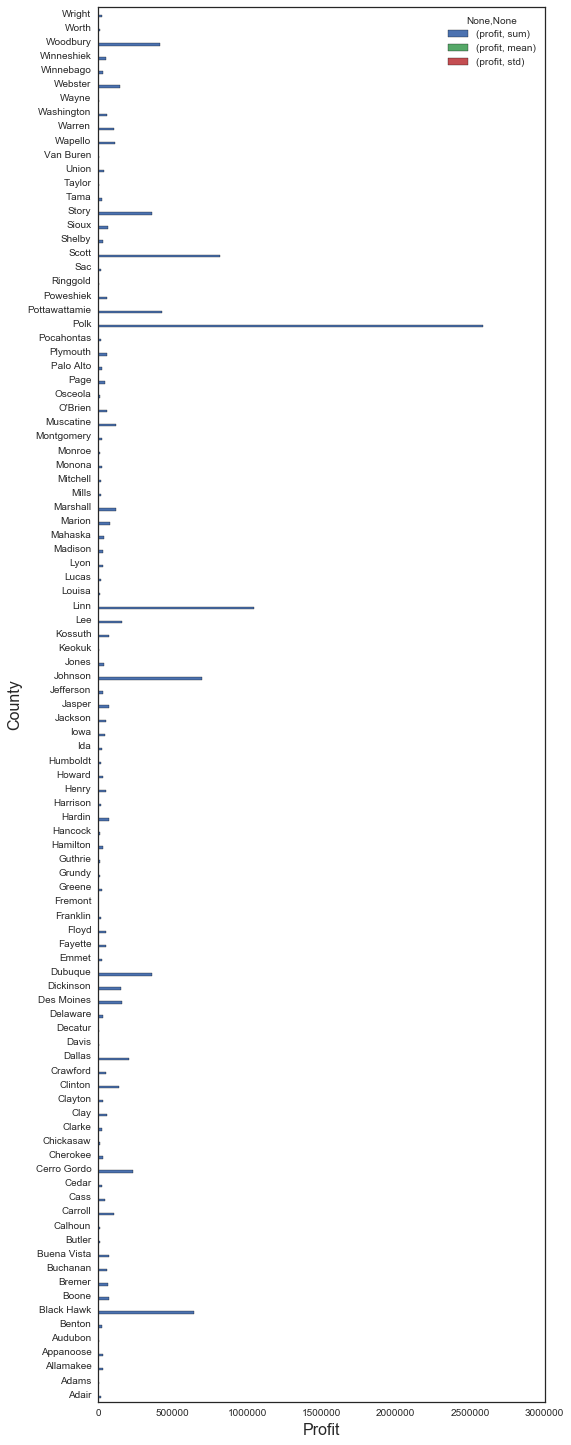

In [131]:
## Graph Profit by County 
# group_county_profit_1 = iowa_clean.groupby(['county'])[['profit']].sum()
# group_county_profi_1 = group_storenum_profit.reset_index()

fig = plt.figure(figsize=(10,30))
graph_1 = group_county_profit.plot(kind = 'barh', figsize = (8,25))
a = plt.yticks(range(len(group_county_profit['county'])), group_county_profit['county'])
plt.xlabel('Profit', fontsize = 16)
plt.ylabel('County', fontsize = 16)
plt.show()

In [121]:
## Profit Total, Average and Standard Deviation by City and County 2015 and 2016
grouped = iowa_clean.groupby(['year', 'city', 'county'])
grouped_profit = grouped[['profit']].agg(['sum', 'mean','std']).reset_index()
grouped_profit.head(4)

year    city   county    profit                       
                               sum       mean         std
0  2015  ACKLEY   Hardin   1100.39  26.838780   24.318717
1  2015  ACKLEY  Webster    867.59  25.517353   13.933717
2  2015   ADAIR    Adair   1663.48  44.958919   25.467143
3  2015    ADEL   Dallas  12734.43  50.533452  130.615305

In [36]:
## Grouping by category name and item description 
group_cat_item = iowa_clean.groupby(['category_name', 'item_description']).size()
group_cat_item.reset_index()
# At the macro level analysis can be done at the category name
# Idea: what city and county sold the most category in 2015 and 2016
# Idea: what type of buzz was sold the most per city and county in 2015 and 2016

,category_name,item_description,0
0,100 PROOF VODKA,Barton Vodka,3
1,100 PROOF VODKA,Blaum Bros. Vodka,1
2,100 PROOF VODKA,Cooper's Chase Vodka Mini,1
3,100 PROOF VODKA,Deep Eddy,4
4,100 PROOF VODKA,Dueces Wild Vodka,40
5,100 PROOF VODKA,Five O'clock PET Vodka,49
6,100 PROOF VODKA,Five O'clock Vodka,303
7,100 PROOF VODKA,Hawkeye Vodka,9
8,100 PROOF VODKA,Hawkeye Vodka 80 Prf Mini,451
9,100 PROOF VODKA,McCormick Vodka,253


In [122]:
## Grouping by category name
group_cate_name = iowa_clean.groupby(['category_name', 'county'])[['bottles_sold']].agg(['sum', 'mean']).reset_index()
group_cate_name.head(4)

category_name     county bottles_sold      
                                       sum  mean
0  100 PROOF VODKA      Adair           60  12.0
1  100 PROOF VODKA      Adams            6   6.0
2  100 PROOF VODKA  Allamakee           64   8.0
3  100 PROOF VODKA  Appanoose           96   8.0

In [126]:
# ## Crostablulations year bottles sold
crosst_bt_year = pd.crosstab(iowa_clean.bottles_sold, [iowa_clean.year]).reset_index()
crosst_bt_year.head(4)

year,bottles_sold,2015,2016
0,1,24891,6167
1,2,30161,7160
2,3,22646,5112
3,4,12265,2786


In [139]:
## Bottles sold by Category Name
group_cate_name = iowa_clean.groupby(['category_name'])[['bottles_sold']].agg(['sum', 'mean', 'std']).reset_index()
group_cate_name.head(4)

category_name bottles_sold                      
                                sum       mean        std
0      100 PROOF VODKA        33512  10.155152  14.203759
1  AMARETTO - IMPORTED           48  16.000000   6.928203
2     AMERICAN ALCOHOL         5769  10.085664   7.304822
3    AMERICAN AMARETTO        10476   7.817910   6.086112

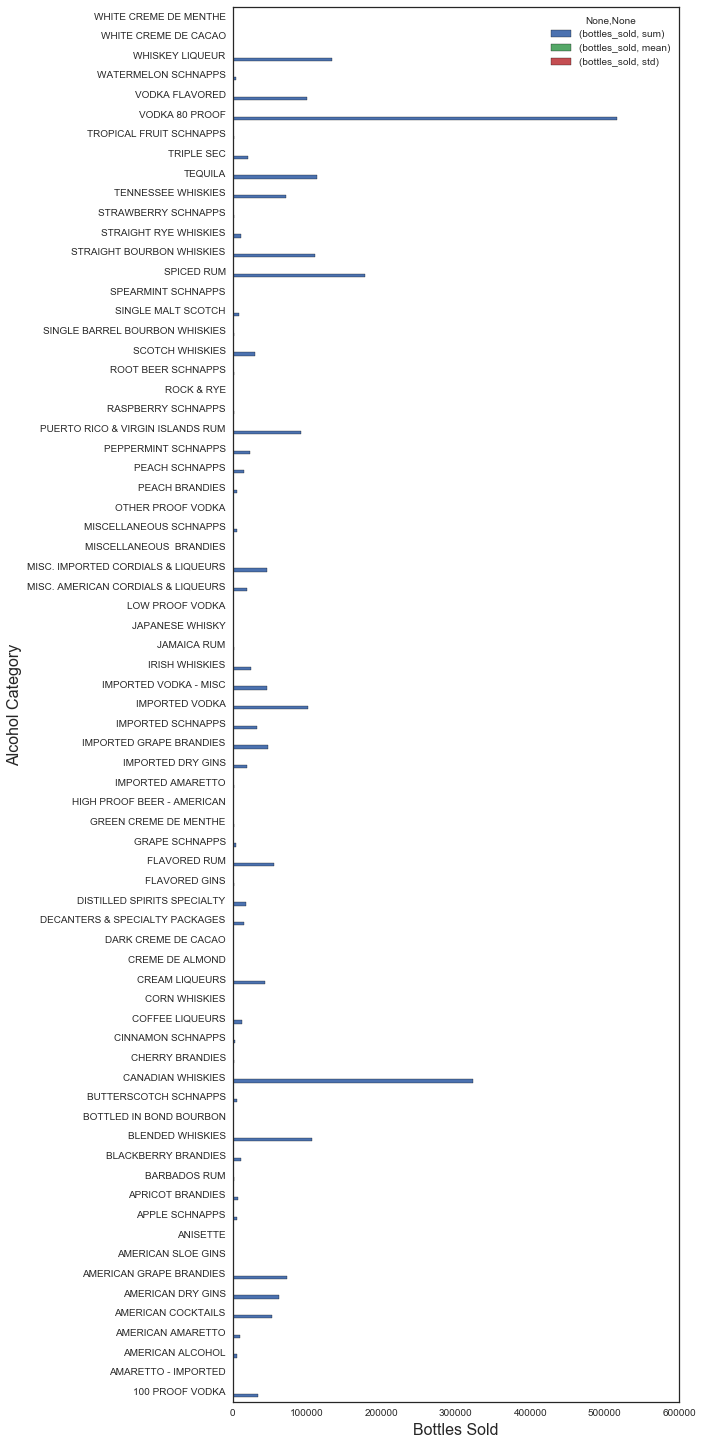

In [129]:
## Graph Bottles sold by Category Name 
fig = plt.figure(figsize=(10,30))
graph_1 = group_cate_name.plot(kind = 'barh', figsize = (8,25))
a = plt.yticks(range(len(group_cate_name['category_name'])),group_cate_name['category_name'])
plt.xlabel('Bottles Sold', fontsize = 16)
plt.ylabel('Alcohol Category', fontsize = 16)
plt.show()

In [378]:
## Yearly Liquor, Total and Average Sales per Store
group_storenum_sales = iowa_clean.groupby(['year', 'store_num'])[['sale_dollars']].agg(['sum', 'mean']).reset_index()
group_storenum_sales.head(5)

year store_num sale_dollars            
                           sum        mean
0  2015      2106    146038.70  277.640114
1  2015      2113      9310.22   63.334830
2  2015      2130    111583.91  285.380844
3  2015      2152      7721.08   54.759433
4  2015      2178     24324.18  102.633671

In [379]:
## Yearly Liquor, Total and Average Profit per Store
group_storenum_profit = iowa_clean.groupby(['year', 'store_num'])[['profit']].agg(['sum', 'mean']).reset_index()
group_storenum_profit.head(5)

year store_num    profit           
                        sum       mean
0  2015      2106  48742.20  92.665779
1  2015      2113   3109.04  21.149932
2  2015      2130  37229.32  95.215652
3  2015      2152   2587.53  18.351277
4  2015      2178   8165.70  34.454430

In [382]:
# # Set the datetime column as the index
iowa_clean_indexed = iowa_clean.copy()
iowa_clean_indexed.index = iowa_clean_indexed['date']
iowa_clean_indexed.head(2)

,date,store_num,city,zip_code,county_number,county,category,category_name,vendor_number,item_number,item_description,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,year,month,profit
date,,,,,,,,,,,,,,,,,,,,
2015-11-04,2015-11-04,3717,SUMNER,50674,9.0,Bremer,1051100.0,APRICOT BRANDIES,55,54436,Mr. Boston Apricot Brandy,750,4.50,6.75,12,81.00,9.0,2015,11,27.00
2016-03-02,2016-03-02,2614,DAVENPORT,52807,82.0,Scott,1011100.0,BLENDED WHISKIES,395,27605,Tin Cup,750,13.75,20.63,2,41.26,1.5,2016,3,13.76


In [393]:
## Profit by month
sub_list = iowa_clean_indexed[['state_bottle_cost', 'state_bottle_retail','bottle_volume_ml','bottles_sold', 'sale_dollars', 'profit']]
tot_sales_month = sub_list.resample('M').agg(['sum'])
tot_sales_month

,state_bottle_cost,state_bottle_retail,bottle_volume_ml,bottles_sold,sale_dollars,profit
,sum,sum,sum,sum,sum,sum
date,,,,,,
2015-01-31,154411.02,231864.76,14829175,145781,1857216.69,621217.26
2015-02-28,152723.40,229426.35,14539200,153502,2036478.82,682840.57
2015-03-31,173028.09,259883.97,16660600,175018,2254625.50,753020.69
2015-04-30,173343.88,260284.01,16541150,179941,2301131.92,768443.68
2015-05-31,167502.07,251599.89,15872525,169469,2257015.51,755854.14
2015-06-30,200465.75,301219.19,19118900,210046,2752100.81,920738.29
2015-07-31,177447.72,266449.42,17106703,174421,2173879.51,726276.58
2015-08-31,172760.24,259411.24,16705606,171543,2163424.36,722538.29


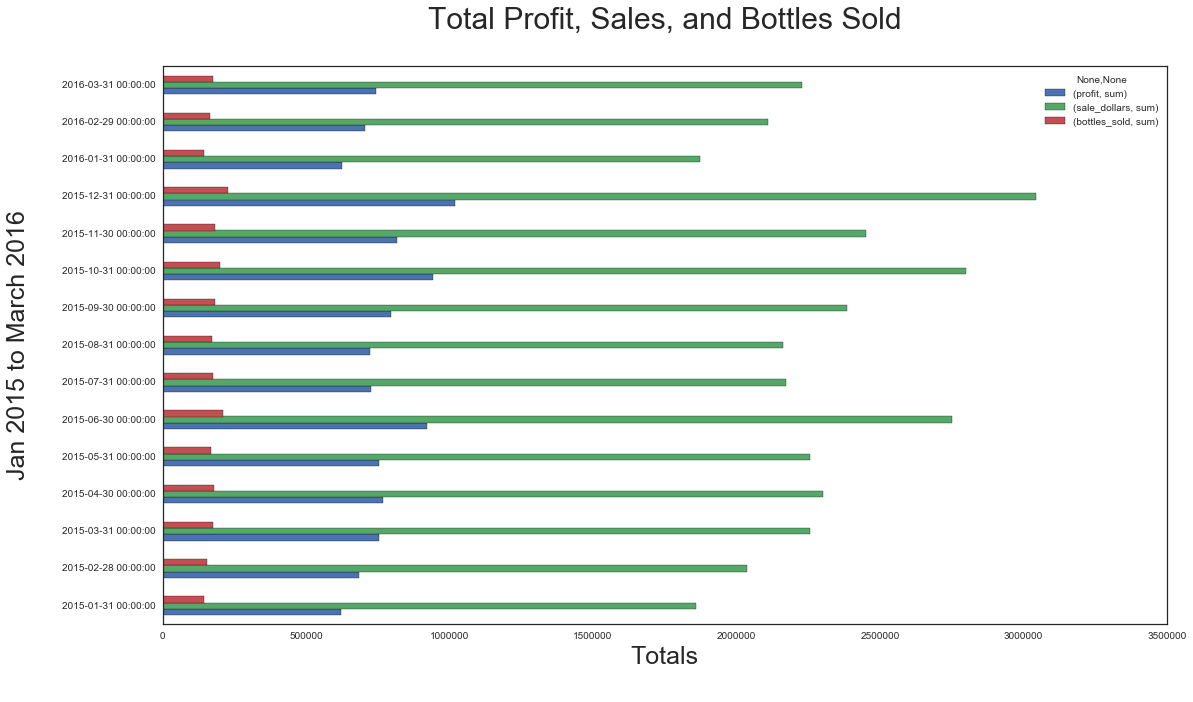

In [395]:
## Barh Plots
sub_list_2 = tot_sales_month[['profit', 'sale_dollars', 'bottles_sold']]
# sub_list_2.head(2)
fig_3 = sub_list_2.plot(kind='barh', sort_columns='descendent', figsize = (18, 10))
plt.title('Total Profit, Sales, and Bottles Sold\n', fontsize = 30)
plt.ylabel('Jan 2015 to March 2016\n', fontsize=25)
plt.xlabel('Totals\n', fontsize=25)
fig.show()

## Record your findings

Be sure to write out anything observations from your exploratory analysis.


* In this analysis, the dataset I am using is the Iowa_Liquor_sales_sample_10pct.
* There are 270955 observations in this dataset which also includes 18 variables/columns.
* There columns Volume Sold (Liters) and Volume Sold (Gallons) describe the same information. I dropped the Volume Sold (Gallons) column.
* There were missing observations for the county number, county, category, and category name columns. 
* I dropped all these missing observations (a total of 1697 observations/entries dropped), leaving a total number of 269258 valid entries for the analysis.
* Further exploration of the data showed that some zip codes don't have a city name assigned, therefore in the analysis I will be considering using zip codes instead of city names. This is not the case for county numbers and county names on which every county number has its correspondent county number.
* The column Category Name groups the type of alcohol and the column Item Description depicts the brand of liquor.
* I transformed to integer type the  County Number column. 
* To facilitate the analysis I created a profit, year_2015, year_2016 and month columns/variables.
* The scatter plots show that total sales are vastly concentrated in between the \$ 0 to \$ 20,000. These sales seem to have a positive correlation with the cost of alcohol bottle between \$0 to \$200, and the retail price per bottle concentrated between \$0 to \$300.
* The number of alcohol bottles sold highly concentrate in the 0 to 500 and are correlated with total sales between \$0 to \$15,000
* In this dataset, the first recorded sales date is January 1st, 2015 and the last recorded sales date is March 31st, 2016.
* There is a total of 1378 unique stores, 99 unique counties,  382 unique cities, 412 unique zip codes, 71 unique alcohol categories, 2158 unique liquor brands, 115 unique vendors,  
* The average number of bottles sold is ~ 10, with a maximum number of 2508 bottles and a minimum number of 1. The average retail price per bottle is \$14.66, with a minimum and maximum retail price of \$1.34 and \$637.500 respectively. 
* The average total sales are \$128.82, the minimum amount of dollars sold is \$1.34 and a maximum sale price of \$36,392.40. In relationship to the profit which was calculated as [(bottle_reatil - bottle_cost) x (bottles_sold)] the average profit is \$43. 
Each of the previously stated variables, present a positive skew distribution and large standard deviations.
* As expected, the number of bottles sold is negatively correlated with the cost and retail price per bottle as well as the bottle volume. 
On the contrary, total sales and profit present positive correlations with the cost and retail price per bottle, the bottle volume, and the number of bottles sold.
* The highest profit is \$12130.80 which comes from store number 2633 located in Des Moines, Polk County. This high profit originates from the sale of 1320  Jack Daniels Old \#7 Black Lbl bottles, belonging to the TENNESSEE WHISKIES alcohol category.
* The largest category of alcohol sold in 2015 and 2016 was Vodka  80 Proof, followed by Canadian Whiskies, Spiced Rum, and Whiskey Liqueur.
* Polk County has the highest profit, followed by Linn, Scott, Johnson, and Black Hawk
* December 2015 has the highest number of bottles sold, therefore, the most top sales and profits. December 2015 largest number of bottles sold, sales and profit, is followed by October 2015, June 2015.
* In 2016, March has the most considerable amount of bottles sold, sales and profit among the first 3 months of 2016. 


# Mine the Data
Compute the variables you will use for your regression from the data. For example, you may want to
compute total sales per store from Jan to March of 2015, mean price per bottle, etc. Refer to the readme for more ideas appropriate to your scenario.

Pandas is your friend for this task. Take a look at the operations [here](http://pandas.pydata.org/pandas-docs/stable/groupby.html) for ideas on how to make the best use of pandas and feel free to search for blog and Stack Overflow posts to help you group data by certain variables and compute sums, means, etc. You may find it useful to create a new data frame to house this summary data

## Compute New Columns and Tables

Since we're trying to predict sales and/or profits, we'll want to compute some intermediate data. There are a lot of ways to do this and good use of pandas is crucial. For example, for each transaction we may want to know:
* margin, retail cost minus bottle cost
* price per bottle
* price per liter

We'll need to make a new dataframe that indexes quantities by store:
* sales per store for all of 2015
* sales per store for Q1 2015
* sales per store for Q1 2016
* total volumes sold
* mean transaction revenue, gross margin, price per bottle, price per liter, etc.
* average sales per day
* number of days open

In [683]:
## Stores that remain open in 2015
mask_open_2015 = (iowa_clean['date'] < '2015-12-31')
stores_open_2015 = iowa_clean[mask_open_2015]

stores_open_2015.head(2)

,date,store_num,city,zip_code,county_number,county,category,category_name,vendor_number,item_number,...,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,year,month,profit,margin,retail_price_lt
0,2015-11-04,3717,SUMNER,50674,9.0,Bremer,1051100.0,APRICOT BRANDIES,55,54436,...,4.5,6.75,12,81.0,9.0,2015,11,27.0,2.25,9.000000
4,2015-08-18,3654,BELMOND,50421,99.0,Wright,1031080.0,VODKA 80 PROOF,297,35918,...,7.2,10.80,12,129.6,21.0,2015,8,43.2,3.60,6.171429


In [754]:
stores_2015 = stores_open_2015.groupby(['store_num','month'])['sale_dollars'].sum()
stores_2015 = pd.DataFrame(stores_2015)
stores_2015 = stores_2015.reset_index()
stores_2015.head(13)

,store_num,month,sale_dollars
0,2106,1,13567.80
1,2106,2,12873.14
2,2106,3,12846.35
3,2106,4,11957.86
4,2106,5,7526.88
5,2106,6,11688.72
6,2106,7,15764.34
7,2106,8,12329.82
8,2106,9,10230.61
9,2106,10,16899.33


In [685]:
## From Long to Wide format to make deletion of missing sales per month easy
stores_2015_wide = pd.pivot_table(stores_2015, 
                         values = ['sale_dollars'],
                         index = ['store_num'],
                         columns =  ['month']
                         )    

In [686]:
stores_2015_wide = stores_2015_wide.reset_index()

In [687]:
print stores_2015_wide.shape
stores_2015_wide.tail(3)

(1372, 13)


store_num sale_dollars                                               \
month                      1        2       3       4       5       6   7   
1369       9010      1039.92  1760.88  1060.8  635.64  239.28  280.68 NaN   
1370       9013          NaN      NaN     NaN     NaN     NaN  677.16 NaN   
1371       9018          NaN      NaN     NaN     NaN     NaN     NaN NaN   

                                             
month       8       9      10     11     12  
1369   393.48  347.28     NaN    NaN    NaN  
1370   165.12     NaN     NaN  556.8  818.4  
1371      NaN     NaN  6435.0    NaN    NaN

In [688]:
## Dropping NaN values per row
stores_2015_wide = stores_2015_wide.dropna() 

In [689]:
stores_2015_wide.tail(3)

store_num sale_dollars                                               \
month                      1        2        3        4        5        6   
1259       5092       997.98   252.00   565.56   137.52   314.52   393.45   
1260       5093       727.88  1093.00   609.69   777.92   480.35   679.67   
1368       9002      1379.28  2186.04  1299.84  4791.12  1636.80  3778.44   

                                                           
month        7       8        9      10       11       12  
1259    477.47  542.95  1006.88  189.39   272.82   666.20  
1260    738.47  411.70  1066.10  517.03  1267.40   397.33  
1368   5831.64  915.60  3433.44  943.80  2895.36  2383.08

In [690]:
print "Stores that remain open 1/1/2015 to 12/31/2105", len(stores_2015_wide.store_num.unique())

Stores that remain open 1/1/2015 to 12/31/2105 829


In [691]:
## From wide to long
unique_stores_2015 = pd.melt(stores_2015_wide,
                        id_vars = ['store_num'],
                        value_vars = ['sale_dollars'],
                        var_name='month',
                         value_name='sale_dollars')

In [692]:
del unique_stores_2015['month']
# del unique_stores_2015['sale_dollars']
unique_stores_2015.head()

,store_num,sale_dollars
0,2106,13567.80
1,2113,813.68
2,2130,7725.66
3,2152,1096.72
4,2178,2251.52


In [693]:
unique_stores_2015.rename(columns={'sale_dollars': 'unique_store_sales'}, inplace=True)

In [694]:
unique_stores_2015.head(2)

,store_num,unique_store_sales
0,2106,13567.80
1,2113,813.68


In [762]:
print "Unique Stores open in 2015: ", len(unique_stores_2015.store_num.unique())
print "Unique Stores 2015 Data Shape: ", unique_stores_2015.shape
print "Original Data Shape: ", iowa_clean.shape

Unique Stores open in 2015:  829
Unique Stores 2015 Data Shape:  (9948, 2)
Original Data Shape:  (269258, 22)


In [763]:
## Crossvalidating the iowa clean data and the unique stores data
iowa_clean_a = iowa_clean.sort_values(by=['date', 'store_num'])
unique_stores_2015_a = unique_stores_2015.sort_values(by=['store_num'])

In [765]:
unique_stores_2015_a.head(24)
## Now I have 12 month worth of sales per each store that remained open in 2015

,store_num,unique_store_sales
0,2106,13567.80
2487,2106,11957.86
829,2106,12873.14
3316,2106,7526.88
9119,2106,9665.47
4145,2106,11688.72
4974,2106,15764.34
7461,2106,16899.33
8290,2106,10688.38
5803,2106,12329.82


In [770]:
## Total and average sales per store in 2015 (stores that remain open during the entire year)
## I need unique store numbers and total sales and average sales
a = unique_stores_2015_a.groupby('store_num')
a = a.agg({'unique_store_sales':[np.sum, np.mean]})
a = a['unique_store_sales'].reset_index()
unique_2015 = a
unique_2015.columns = ['store_num', 'tot_sales_2015', 'ave_sales_2015']
unique_2015.head(4)

,store_num,tot_sales_2015,ave_sales_2015
0,2106,146038.70,12169.891667
1,2113,9310.22,775.851667
2,2130,111583.91,9298.659167
3,2152,7721.08,643.423333


In [830]:
# Sales per Store Q1 2015
# liquor_sales_2015.head(2)
mask_2015 = (iowa_clean['date'] < '2015-12-31')
liquor_sales_2015 = iowa_clean[mask_2015]

mask_Jan_Mar = (liquor_sales_2015 ['month']==1) | (liquor_sales_2015['month']==2)|(liquor_sales_2015['month']==3)
liquor_sales_Jan_Mar_2015 = liquor_sales_2015[mask_Jan_Mar]

iowa_grouped_jm_2015 = liquor_sales_Jan_Mar_2015.groupby(['store_num'])['sale_dollars'].sum()
iowa_grouped_jm_2015 = pd.DataFrame(iowa_grouped_jm_2015)
iowa_grouped_jm_2015 = iowa_grouped_jm_2015.reset_index()
iowa_grouped_jm_2015.rename(columns={'sale_dollars': 'st_sales_Q1_2015'}, inplace=True)
iowa_grouped_jm_2015.head(4)

,store_num,st_sales_Q1_2015
0,2106,39287.29
1,2113,2833.25
2,2130,24272.57
3,2152,2003.46


In [831]:
print "Shape Unique Store 2015 Data: ", unique_2015.shape
print "Shape Unique Store 2015 Data: ", iowa_grouped_jm_2015.shape

Shape Unique Store 2015 Data:  (829, 3)
Shape Unique Store 2015 Data:  (1261, 2)


In [832]:
## Need to make sure the same stores are included in the entire analysis
store_sales_Q2015 = iowa_grouped_jm_2015[iowa_grouped_jm_2015['store_num'].isin(unique_2015['store_num'].unique())]

In [833]:
store_sales_Q2015.shape

(829, 2)

In [826]:
store_sales_Q2015.head()

,store_num,st_sales_Q_12015
0,2106,39287.29
1,2113,2833.25
2,2130,24272.57
3,2152,2003.46
4,2178,5856.41


In [834]:
## Now merging all 2015 unique information
store_sales_2015 = pd.merge(unique_2015, store_sales_Q2015, on='store_num', how='outer')

In [835]:
store_sales_2015.shape

(829, 4)

In [836]:
store_sales_2015.head(3)
## Looking good

,store_num,tot_sales_2015,ave_sales_2015,st_sales_Q1_2015
0,2106,146038.70,12169.891667,39287.29
1,2113,9310.22,775.851667,2833.25
2,2130,111583.91,9298.659167,24272.57


In [838]:
## Total sales 2016, which is Q1 2016
mask_2016 = ((iowa_clean['date'] > '2015-12-31') & (iowa_clean['date'] < '2016-12-31'))
liquor_sales_2016 = iowa_clean[mask_2016]

iowa_grouped_16 = liquor_sales_2016.groupby(['store_num'])['sale_dollars'].sum() ## I can add year in here
iowa_grouped_16 = pd.DataFrame(iowa_grouped_16)
iowa_grouped_16 = iowa_grouped_16.reset_index()
iowa_grouped_16.rename(columns={'sale_dollars': 'st_sales_Q1_2016'}, inplace=True)
iowa_grouped_16.head(4)

,store_num,st_sales_Q1_2016
0,2106,30478.75
1,2113,2065.90
2,2130,27856.11
3,2152,904.66


In [839]:
iowa_grouped_16.shape

(1280, 2)

In [840]:
## For Analysis I need to make sure that stores that opened in 2015 in the entire year are also opened in the Q1 of 2016
store_sales_Q2016 = iowa_grouped_16[iowa_grouped_16['store_num'].isin(unique_2015['store_num'].unique())]

In [841]:
store_sales_Q2016.shape

(820, 2)

In [842]:
store_sales_15_16 = pd.merge(store_sales_Q2016, store_sales_2015, on='store_num', how='outer')

In [843]:
store_sales_15_16.isnull()

,store_num,st_sales_Q1_2016,tot_sales_2015,ave_sales_2015,st_sales_Q1_2015
0,False,False,False,False,False
1,False,False,False,False,False
2,False,False,False,False,False
3,False,False,False,False,False
4,False,False,False,False,False
5,False,False,False,False,False
6,False,False,False,False,False
7,False,False,False,False,False
8,False,False,False,False,False
9,False,False,False,False,False


In [844]:
sales_unique_15_16= store_sales_15_16.dropna()

In [847]:
sales_unique_15_16['store_num'] = sales_unique_15_16['store_num'].astype(int)
sales_unique_15_16.head(10)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,store_num,st_sales_Q1_2016,tot_sales_2015,ave_sales_2015,st_sales_Q1_2015
0,2106,30478.75,146038.70,12169.891667,39287.29
1,2113,2065.90,9310.22,775.851667,2833.25
2,2130,27856.11,111583.91,9298.659167,24272.57
3,2152,904.66,7721.08,643.423333,2003.46
4,2178,5588.50,24324.18,2027.015000,5856.41
5,2190,31803.06,121689.06,10140.755000,29452.92
6,2191,47338.20,125093.49,10424.457500,29085.57
7,2200,4174.87,22811.55,1900.962500,4900.43
8,2228,3086.38,17462.07,1455.172500,5193.97
9,2233,6522.65,29553.34,2462.778333,5374.55


[   0.95995767  211.05738842]


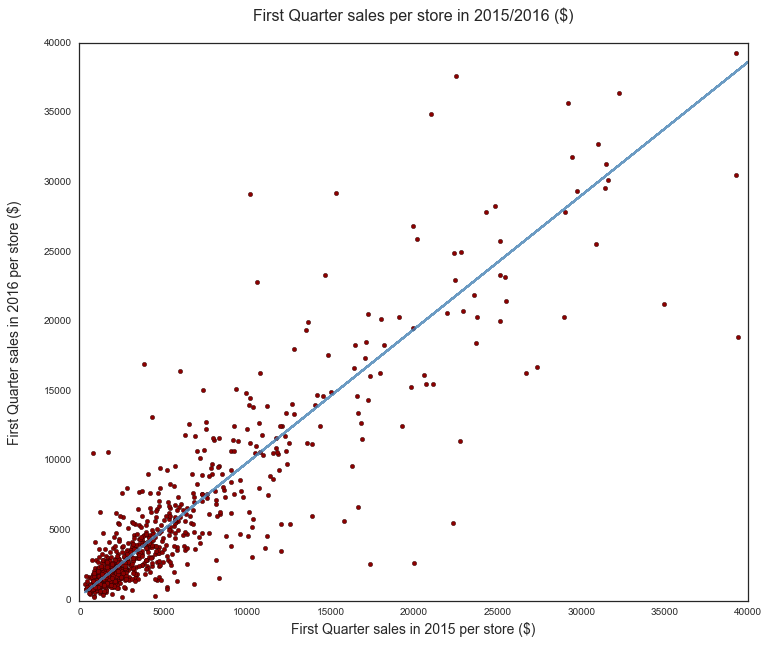

In [860]:
## Graph comparing Trends in both quaters 
fig = plt.figure(figsize=(12,10))
ax = fig.gca()
ax.scatter(sales_unique_15_16['st_sales_Q1_2015'], sales_unique_15_16['st_sales_Q1_2016'], c='darkred')
plt.ylim(-100,40000)
plt.xlim(-100, 40000)
fit = np.polyfit(sales_unique_15_16['st_sales_Q1_2015'], sales_unique_15_16['st_sales_Q1_2016'], 1)

yhat = [fit[0]*i + fit[1] for i in sales_unique_15_16['st_sales_Q1_2015']]

ax.plot(sales_unique_15_16['st_sales_Q1_2015'], yhat, c = 'steelblue', alpha = 0.8)

plt.xlabel('First Quarter sales in 2015 per store ($)\n', fontsize = 14)
plt.ylabel('First Quarter sales in 2016 per store ($)\n', fontsize = 14)
plt.title('First Quarter sales per store in 2015/2016 ($)\n', fontsize=16)
print fit

In [964]:
## Control Variables
iowa_clean['margin'] = (iowa_clean['state_bottle_retail']- iowa_clean['state_bottle_cost']) ## I am not sure about this guy check
iowa_clean['retail_price_lt'] = (iowa_clean['state_bottle_retail']/((iowa_clean['bottle_volume_ml'])*0.001) ) 
## Price per Bottle??

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [965]:
## Need to make sure my iowa_clean has same store numbers as sales_unique_15_16
iowa_clean_A = iowa_clean[iowa_clean['store_num'].isin(unique_2015['store_num'].unique())]

In [966]:
print iowa_clean.shape
print iowa_clean_A.shape

(269258, 22)
(241777, 22)


In [967]:
# Filtering by our start and end dates
iowa_clean_A.sort_values(by=["store_num", "date"], inplace=True)
start_date = pd.Timestamp("20150101")
end_date = pd.Timestamp("20151231")
mask = (iowa_clean_A['date'] >= start_date) & (iowa_clean_A['date'] <= end_date)
sales = iowa_clean_A[mask]

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [968]:
# Group by store number
sales = iowa_clean_A.groupby(by=["store_num"], as_index=False)

# Compute sums, means
sales = sales.agg({"sale_dollars": [np.sum, np.mean],
                   "volume_sold_liters": [np.sum, np.mean],
                   "bottle_volume_ml" :[np.sum, np.mean],
                   "bottles_sold" :[np.sum, np.mean],
                   "state_bottle_cost" : np.mean,
                   "state_bottle_retail" : np.mean, 
                   "margin": np.mean,
                   "retail_price_lt": np.mean,
                   "profit" :np.sum,
                   "zip_code": lambda x: x.iloc[0], # just extract once, should be the same
                   "city": lambda x: x.iloc[0],
                   "county" : lambda x: x.iloc[0],
                   "county_number": lambda x: x.iloc[0]})

# Collapse the column indices
sales.columns = [' '.join(col).strip() for col in sales.columns.values]

## average sales per day ??
## number of days open ??

In [969]:
## Renaming columns
sales.rename(columns={'bottles_sold sum': 'tot_bottles_sold',
                      'bottles_sold mean' : 'ave_bottles_sold',
                      "bottle_volume_ml sum": 'tot_bottle_volume_ml',
                      'bottle_volume_ml mean' : 'ave_bottle_volume_ml',
                      'sale_dollars sum': 'total_sales_2015',
                      'sale_dollars mean': 'average_sale_2015',
                      'state_bottle_cost mean': 'ave_state_bottle_cost',
                      'retail_price_lt mean' : 'ave_retail_price_lt',
                      'city <lambda>' :'city',
                      'county <lambda>': 'county',
                      'profit sum' : 'tot_profit',
                      'county_number <lambda>' : 'county_number',
                      'volume_sold_liters sum' : 'tot_volume_sold_lit',
                      'volume_sold_liters mean' : 'ave_volume_sold_lit',
                      'state_bottle_retail mean' : 'ave_state_bottle_retail',
                      'margin mean': 'ave_margin',
                      'zip_code <lambda>': 'zip_code'}, inplace=True)

In [970]:
sales.head(3)

,store_num,tot_bottles_sold,ave_bottles_sold,tot_bottle_volume_ml,ave_bottle_volume_ml,total_sales_2015,average_sale_2015,ave_state_bottle_cost,county,ave_retail_price_lt,city,tot_profit,county_number,tot_volume_sold_lit,ave_volume_sold_lit,ave_state_bottle_retail,ave_margin,zip_code
0,2106,12573,19.283742,595600,913.496933,176517.45,270.732285,10.311273,Black Hawk,17.869110,CEDAR FALLS,58916.88,7.0,11836.10,18.153528,15.479095,5.167822,50613
1,2113,830,4.510870,175625,954.483696,11376.12,61.826739,10.838152,Webster,18.298929,GOWRIE,3802.53,94.0,836.85,4.548098,16.267717,5.429565,50543
2,2130,9144,18.000000,475375,935.777559,139440.02,274.488228,10.006398,Black Hawk,16.963631,WATERLOO,46517.61,7.0,8436.27,16.606831,15.015197,5.008799,50703


In [971]:
sales.shape

(829, 18)

In [972]:
## Merging datasets for analysis
iowa_sales = pd.merge(sales, sales_unique_15_16, on='store_num', how='outer')

In [973]:
iowa_sales_A = iowa_sales.dropna()

In [974]:
iowa_sales_A.shape

(820, 22)

## Adding Poverty Rate

In [975]:
import requests
response = requests.get("http://www.indexmundi.com/facts/united-states/quick-facts/iowa/percent-of-people-of-all-ages-in-poverty#table")
HTML = response.text  
HTML[0:500] 

u'\r\n<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Strict//EN" "http://www.w3.org/TR/xhtml1/DTD/xhtml1-strict.dtd">\r\n<html xmlns="http://www.w3.org/1999/xhtml">\r\n<head><title>\r\n\tIowa Poverty Rate by County\r\n</title>\r\n    <meta name="Description" content="Map, bar chart, and table showing Persons below poverty level, percent, 2009-2013 by county. The source of the data is the US Census Bureau." />\r\n    <link href="../../../Content/TaxViewer.css" rel="stylesheet" type="text/css" />\r\n    <style type="t'

In [976]:
## County Names and Values
names = []
values = []
for node in Selector(text=HTML).xpath('//div[@id="tableTab"]/table/tbody/tr'):
    names.append(node.xpath("td[1]/text()").extract()[0])
    values.append(node.xpath("td[2]/text()").extract()[0])

In [977]:
povert_rate = zip(names, values)
povert_rate = pd.DataFrame(povert_rate, columns= ['county', 'pov_rate'])
povert_rate.head(2)

,county,pov_rate
0,Adair,9.5
1,Adams,11.3


In [978]:
from pandas_summary import DataFrameSummary
dfs = DataFrameSummary(povert_rate)
dfs[0]

counts              99
uniques             99
missing              0
missing_perc        0%
types           unique
Name: county, dtype: object

In [979]:
## Merging datasets for analysis
iowa_pre_final = pd.merge(iowa_sales_A, povert_rate, on='county', how='outer')
# iowa_final.head(10)

In [980]:
iowa_pre_final.shape

(822, 23)

In [981]:
iowa_final = iowa_pre_final.dropna()

In [982]:
iowa_final['store_num'] =iowa_final['store_num'].astype(int)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [983]:
iowa_final.shape

(820, 23)

In [984]:
del iowa_final['tot_sales_2015']
del iowa_final['ave_sales_2015']

In [985]:
iowa_final.head(3)

,store_num,tot_bottles_sold,ave_bottles_sold,tot_bottle_volume_ml,ave_bottle_volume_ml,total_sales_2015,average_sale_2015,ave_state_bottle_cost,county,ave_retail_price_lt,...,tot_profit,county_number,tot_volume_sold_lit,ave_volume_sold_lit,ave_state_bottle_retail,ave_margin,zip_code,st_sales_Q1_2016,st_sales_Q1_2015,pov_rate
0,2106,12573.0,19.283742,595600.0,913.496933,176517.45,270.732285,10.311273,Black Hawk,17.869110,...,58916.88,7.0,11836.10,18.153528,15.479095,5.167822,50613,30478.75,39287.29,17.0
1,2130,9144.0,18.000000,475375.0,935.777559,139440.02,274.488228,10.006398,Black Hawk,16.963631,...,46517.61,7.0,8436.27,16.606831,15.015197,5.008799,50703,27856.11,24272.57,17.0
2,2538,5168.0,5.866061,791100.0,897.956867,71386.17,81.028570,10.450159,Black Hawk,20.199204,...,23856.66,7.0,4995.96,5.670783,15.689047,5.238888,50702,16258.06,10779.48,17.0


In [986]:
iowa_final['pov_rate'] = iowa_final['pov_rate'].convert_objects(convert_numeric=True)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  if __name__ == '__main__':
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [987]:
iowa_final.tail(3)

,store_num,tot_bottles_sold,ave_bottles_sold,tot_bottle_volume_ml,ave_bottle_volume_ml,total_sales_2015,average_sale_2015,ave_state_bottle_cost,county,ave_retail_price_lt,...,tot_profit,county_number,tot_volume_sold_lit,ave_volume_sold_lit,ave_state_bottle_retail,ave_margin,zip_code,st_sales_Q1_2016,st_sales_Q1_2015,pov_rate
817,4419,396.0,6.387097,46475.0,749.596774,4564.44,73.620000,7.434355,Decatur,16.794286,...,1528.87,27.0,328.21,5.293710,11.180968,3.746613,50140,445.35,1156.18,19.5
818,4589,454.0,4.365385,101225.0,973.317308,5971.89,57.422019,9.454904,Osceola,15.770014,...,1996.17,72.0,467.22,4.492500,14.207308,4.752404,51249,889.21,1921.02,8.6
819,4891,1678.0,6.793522,268475.0,1086.943320,24341.52,98.548664,10.754251,Osceola,17.126927,...,8138.64,72.0,1784.40,7.224291,16.154170,5.399919,51249,4967.50,5302.66,8.6


In [988]:
iowa_final.to_csv("sales_iowa_final.csv")

# Refine the data
Look for any statistical relationships, correlations, or other relevant properties of the dataset.

In [989]:
iowa_final.corr()

,store_num,tot_bottles_sold,ave_bottles_sold,tot_bottle_volume_ml,ave_bottle_volume_ml,total_sales_2015,average_sale_2015,ave_state_bottle_cost,ave_retail_price_lt,tot_profit,county_number,tot_volume_sold_lit,ave_volume_sold_lit,ave_state_bottle_retail,ave_margin,st_sales_Q1_2016,st_sales_Q1_2015,pov_rate
store_num,1.000000,-0.346867,0.090082,-0.595331,-0.279022,-0.334481,-0.037042,-0.294934,0.055620,-0.334980,0.001526,-0.369314,-0.077309,-0.295301,-0.296023,-0.320811,-0.320687,-0.028231
tot_bottles_sold,-0.346867,1.000000,0.409390,0.745892,-0.007931,0.987668,0.397933,0.251124,0.179265,0.987653,0.050851,0.984589,0.390080,0.250804,0.250156,0.964778,0.969153,0.064188
ave_bottles_sold,0.090082,0.409390,1.000000,0.000866,-0.027314,0.415595,0.875912,0.139423,0.149946,0.416060,0.017127,0.417753,0.859211,0.139001,0.138154,0.380493,0.401292,0.074235
tot_bottle_volume_ml,-0.595331,0.745892,0.000866,1.000000,0.086122,0.724080,0.095700,0.323933,0.140384,0.724299,0.020291,0.736270,0.078754,0.323868,0.323726,0.707579,0.704057,0.045664
ave_bottle_volume_ml,-0.279022,-0.007931,-0.027314,0.086122,1.000000,0.060025,0.212671,0.539682,-0.501486,0.060454,-0.106323,0.098278,0.348734,0.541181,0.544151,0.057433,0.055188,-0.141474
total_sales_2015,-0.334481,0.987668,0.415595,0.724080,0.060025,1.000000,0.457922,0.319645,0.167171,0.999997,0.049522,0.992773,0.446118,0.319402,0.318905,0.977034,0.981835,0.047176
average_sale_2015,-0.037042,0.397933,0.875912,0.095700,0.212671,0.457922,1.000000,0.421293,0.140094,0.458489,0.010062,0.454249,0.947057,0.421170,0.420910,0.420497,0.435860,0.031263
ave_state_bottle_cost,-0.294934,0.251124,0.139423,0.323933,0.539682,0.319645,0.421293,1.000000,0.356929,0.319821,0.005163,0.308253,0.360089,0.999994,0.999943,0.299860,0.310216,0.008534
ave_retail_price_lt,0.055620,0.179265,0.149946,0.140384,-0.501486,0.167171,0.140094,0.356929,1.000000,0.166933,0.111080,0.122486,-0.037260,0.355518,0.352687,0.154172,0.164883,0.134039
tot_profit,-0.334980,0.987653,0.416060,0.724299,0.060454,0.999997,0.458489,0.319821,0.166933,1.000000,0.049379,0.992911,0.446930,0.319581,0.319088,0.976980,0.981860,0.047103


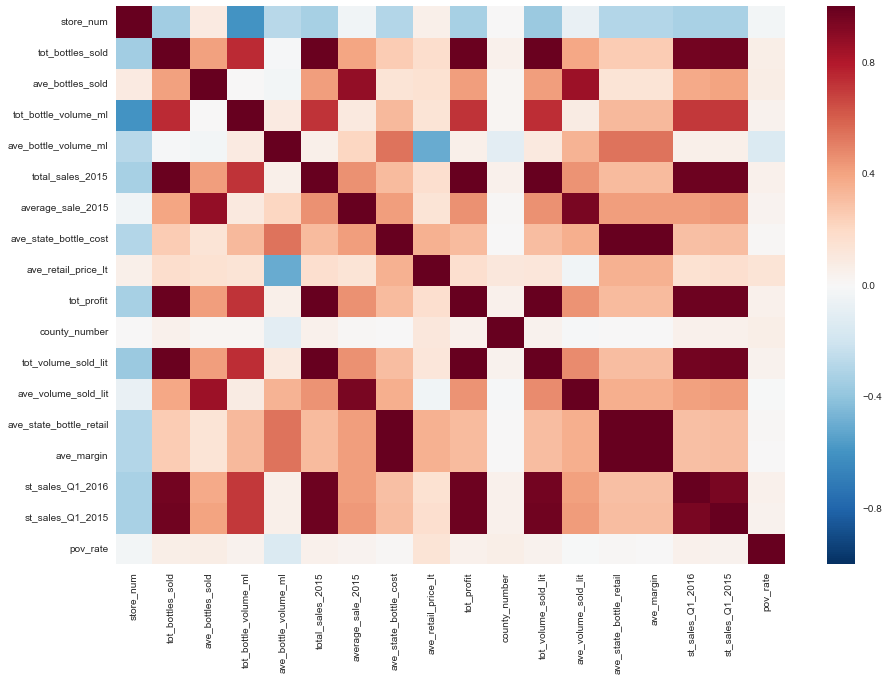

In [990]:
fig = plt.figure(figsize=(15,10))
sns.heatmap(iowa_final.corr())

In [896]:
# ## Creating dummies for categories of liquor
# #affair['affair_binary'] = affair.nbaffairs.map(lambda x :0 if  x==0 else 1)
# iowa_2015['cat_liquor'] = iowa_2015.category_name.map(lambda x :0 if  x==0 else 1)
# # liq_cat_dummies = pd.get_dummies(iowa_2015.category_name, prefix='Categ_').iloc[:, 1:]
# # ## Change this liq_cat_dummies to integers

# # ## Concantenate dumies back to the iowa_2015 data set
# # iowa_2015 = pd.concat([iowa_2015, liq_cat_dummies], axis=1)
# # iowa_2015.head(2)
# iowa_2015.head(1)

# Build your models

Using scikit-learn or statsmodels, build the necessary models for your scenario. Evaluate model fit.

### My model
y = β0 + β1x + β2x + β3x + β4x + β5x + β6x + e

* β1 = ave_bottle_volume_ml ~ Average volume of bottle in ml
* β2 = ave_state_bottle_cost ~ Average state bottle cost
* β3 = ave_retail_price_lt ~ Average retail price per liters
* β4 = ave_volume_sold_lit ~ Average alcohol volume sold in liters
* β5 = st_sales_Q1_2015 ~ Store Sales in the First Quarter if 2015
* β6 = pov_rate ~ County Poverty Rate

     ave_bottle_volume_ml  ave_state_bottle_cost  ave_retail_price_lt  \
524            561.515152               6.780848            20.555550   
789           1135.036496               9.185839            13.678172   
229            948.084610              10.660646            19.178339   
18             542.088608               7.820823            22.503577   
207            787.272727               7.603364            15.691784   
757           1233.823529               8.835647            11.621199   
68            1073.943662               9.152864            14.357387   
103           1166.087963              10.235741            15.087229   
323            872.727273               8.817143            16.333210   
808            900.109170               7.737074            14.547995   
396           1086.864407              12.125627            18.770526   
533            965.139442               9.953685            17.606278   
798           1225.130890              10.586806   

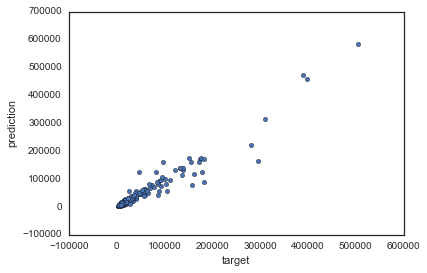

In [1069]:
from sklearn.linear_model import LinearRegression
from sklearn.datasets import load_diabetes
from sklearn.cross_validation import train_test_split

## Cross Validation
lm = linear_model.LinearRegression()
control_var = [ 'ave_bottle_volume_ml', 'ave_state_bottle_cost', 'ave_retail_price_lt','ave_volume_sold_lit', 
               'st_sales_Q1_2015', 'pov_rate']

## not included 
## 'tot_bottles_sold', 'tot_bottle_volume_ml', 'tot_profit', 'tot_volume_sold_lit', 'ave_bottles_sold', 'ave_margin'
## 'ave_state_bottle_retail'

# Setup our X (control var), y (response / prediction target)
X = iowa_final[control_var]
y = iowa_final["total_sales_2015"]

# Split our data by 70% training (for fitting) and 30% testing (for prediction)
X_train, x_test, Y_train, y_test = train_test_split(X, y, train_size=.7)

# Fit our model
model = lm.fit(X_train, Y_train)

# Check accuracy / variance
score_r2 = model.score(x_test, y_test)

# Predicted values from the test data
predictions = model.predict(x_test)


# To look at test data with independent variables (predictors)
# we'll setup a summary dataframe to capture the output of our model predictions for our test data
summary_df = pd.DataFrame(x_test)
summary_df['target'] = y_test
summary_df = summary_df.rename(columns={0:"A", 1:"B", 3:"C", 4:"D", 5:"E", 6:"F", 7:"G"})

summary_df['target'] = y_test

# We capture our predictions in into a new column from the model.predict method
summary_df['prediction'] = predictions

print summary_df

# Additional metrics
print "R2 Score:", score_r2
print "Intercept: ", lm.intercept_
print "(Variable, Coef):", zip(control_var, lm.coef_) ## predictor var = control var

summary_df.plot(kind="scatter", x="target", y="prediction")


Cross-validated scores: [ 0.97192447  0.97676122  0.9364299   0.91276479  0.92616     0.83595321]
Cross-Predicted Accuracy: 0.961439629889


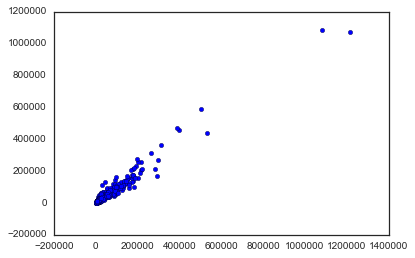

In [1077]:
# k-fold regression
lr = linear_model.LinearRegression()
control_var = [ 'ave_bottle_volume_ml', 'ave_state_bottle_cost',
                'ave_retail_price_lt','ave_volume_sold_lit', 
                'st_sales_Q1_2015', 'pov_rate']
## not included 
## 'tot_bottles_sold', 'tot_bottle_volume_ml', 'tot_profit', 'tot_volume_sold_lit', 'ave_bottles_sold', 'ave_margin'
## 'ave_state_bottle_retail'


# Setup our X (control var), y (response / prediction target)
X = iowa_final[control_var]
y = iowa_final["total_sales_2015"]

# init our linear regression class / object
lm = LinearRegression()

# Fit our training data
model = lm.fit(X, y)

# Perform 6-fold cross validation
scores = cross_val_score(lm, X, y, cv=6)
print "Cross-validated scores:", scores

# Make cross validated predictions
predictions = cross_val_predict(model, X, y, cv=6)
plt.scatter(y, predictions)

## Getting error name 'metrics' is not defined
accuracy = metrics.r2_score(y, predictions)

print "Cross-Predicted Accuracy:", accuracy


In [1063]:
## Regression 2015 
lm = smf.ols(formula='total_sales_2015 ~ ave_bottle_volume_ml + ave_state_bottle_cost + ave_retail_price_lt +ave_volume_sold_lit  + st_sales_Q1_2015 + pov_rate', data=iowa_final).fit()
lm.params
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       total_sales_2015   R-squared:                       0.965
Model:                            OLS   Adj. R-squared:                  0.965
Method:                 Least Squares   F-statistic:                     3753.
Date:                Thu, 05 May 2016   Prob (F-statistic):               0.00
Time:                        01:53:39   Log-Likelihood:                -9008.0
No. Observations:                 820   AIC:                         1.803e+04
Df Residuals:                     813   BIC:                         1.806e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------
Intercept               732.4066   6380.220      0.115      0.909     -1.18e+04  1.33e+04
ave_bottle_volume_ml    -10.7338      6.767     -1.586      0.113       -24.017     2.550
ave_state_bottle_cost  1252.0566    694.919      1.802      0.072      -111.990  2616.103
ave_retail_price_lt    -294.4165    297.528     -0.990      0.323      -878.431   289.598
ave_volume_sold_lit     331.0185     76.180      4.345      0.000       181.485   480.552
st_sales_Q1_2015          5.3076      0.042    126.000      0.000         5.225     5.390
pov_rate                134.9384    155.313      0.869      0.385      -169.923   439.799
==============================================================================
Omnibus:                      258.040   Durbin-Watson:                   1.954
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            13021.694
Skew:                           0.600   Prob(JB):                         0.00
Kurtosis:                      22.485   Cond. No.                     1.98e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.98e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Plot your results

Again make sure that you record any valuable information. For example, in the tax scenario, did you find the sales from the first three months of the year to be a good predictor of the total sales for the year? Plot the predictions versus the true values and discuss the successes and limitations of your models

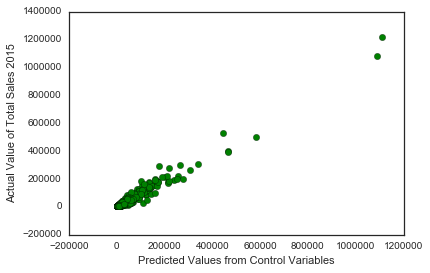

MSE: 203848664.564


In [1032]:
targets = pd.DataFrame(iowa_final.total_sales_2015, columns=["total_sales_2015"])

lm = linear_model.LinearRegression()

X = iowa_final[[ 'ave_bottle_volume_ml', 'ave_state_bottle_cost', 'ave_retail_price_lt', 'ave_volume_sold_lit', 'st_sales_Q1_2015', 'pov_rate']]
y = targets["total_sales_2015"]

model = lm.fit(X, y)
predictions = lm.predict(X)

# Plot the model
## s = s: size in points, c = color, zorder = layer order
plt.scatter(predictions, y, s=40, c='green', marker='o', zorder=10)
plt.xlabel("Predicted Values from Control Variables")
plt.ylabel("Actual Value of Total Sales 2015")
plt.show()
print "MSE:", mean_squared_error(y, predictions)

### Now using the model in the Q1 2016 sales data

In [1036]:
## Regression 2016 data 
lm = smf.ols(formula='st_sales_Q1_2016 ~ ave_bottle_volume_ml + ave_state_bottle_cost + ave_retail_price_lt +ave_volume_sold_lit  + st_sales_Q1_2015 + pov_rate', data=iowa_final).fit()
lm.params
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       st_sales_Q1_2016   R-squared:                       0.900
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                     1221.
Date:                Thu, 05 May 2016   Prob (F-statistic):               0.00
Time:                        00:55:56   Log-Likelihood:                -8049.0
No. Observations:                 820   AIC:                         1.611e+04
Df Residuals:                     813   BIC:                         1.614e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------
Intercept              -107.2783   1981.144     -0.054      0.957     -3996.039  3781.482
ave_bottle_volume_ml     -0.6480      2.101     -0.308      0.758        -4.773     3.477
ave_state_bottle_cost   106.6526    215.782      0.494      0.621      -316.902   530.207
ave_retail_price_lt     -42.6613     92.387     -0.462      0.644      -224.006   138.683
ave_volume_sold_lit      13.8774     23.655      0.587      0.558       -32.555    60.309
st_sales_Q1_2015          0.9544      0.013     72.968      0.000         0.929     0.980
pov_rate                 46.3658     48.227      0.961      0.337       -48.298   141.029
==============================================================================
Omnibus:                      242.446   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            21722.490
Skew:                           0.184   Prob(JB):                         0.00
Kurtosis:                      28.212   Cond. No.                     1.98e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.98e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

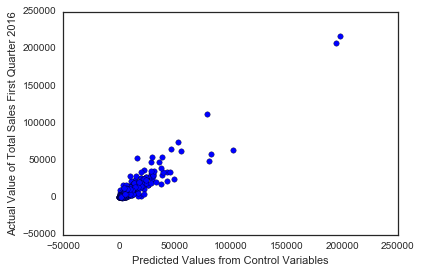

MSE: 19654802.6737


In [1037]:
targets = pd.DataFrame(iowa_final.st_sales_Q1_2016, columns=["st_sales_Q1_2016"])

lm = linear_model.LinearRegression()

X = iowa_final[[ 'ave_bottle_volume_ml', 'ave_state_bottle_cost', 'ave_retail_price_lt', 'ave_volume_sold_lit', 'st_sales_Q1_2015', 'pov_rate']]
y = targets["st_sales_Q1_2016"]

model = lm.fit(X, y)
predictions = lm.predict(X)



# Plot the model
## s = s: size in points, c = color, zorder = layer order
plt.scatter(predictions, y, s=30, c='b', marker='o', zorder=10)
plt.xlabel("Predicted Values from Control Variables")
plt.ylabel("Actual Value of Total Sales First Quarter 2016")
plt.show()
print "MSE:", mean_squared_error(y, predictions)

# Present the Results

Present your conclusions and results. If you have more than one interesting model feel free to include more than one along with a discussion. Use your work in this notebook to prepare your write-up.

In [1071]:
iowa_final.describe()

,store_num,tot_bottles_sold,ave_bottles_sold,tot_bottle_volume_ml,ave_bottle_volume_ml,total_sales_2015,average_sale_2015,ave_state_bottle_cost,ave_retail_price_lt,tot_profit,county_number,tot_volume_sold_lit,ave_volume_sold_lit,ave_state_bottle_retail,ave_margin,st_sales_Q1_2016,st_sales_Q1_2015,pov_rate
count,820.000000,820.000000,820.000000,8.200000e+02,820.000000,8.200000e+02,820.000000,820.000000,820.000000,820.000000,820.000000,820.000000,820.000000,820.000000,820.000000,820.000000,820.000000,820.000000
mean,3963.674390,2871.428049,9.858579,2.727022e+05,939.455419,3.816206e+04,121.584505,9.356172,17.173421,12758.915305,55.919512,2660.504085,8.841756,14.050529,4.694357,6767.263280,6829.682305,12.445244
std,819.383919,4818.970203,6.884179,2.920748e+05,193.412438,7.652721e+04,128.326482,1.765882,3.872493,25547.461008,28.333284,4824.356700,7.828370,2.650490,0.884642,14037.999122,13872.469490,3.278191
min,2106.000000,202.000000,2.143406,2.442500e+04,418.675889,2.882350e+03,23.210524,4.559130,10.182243,962.720000,1.000000,161.720000,1.684583,6.844743,2.285613,130.810000,284.310000,6.400000
25%,3625.750000,827.750000,6.226122,9.100000e+04,816.132851,8.908530e+03,69.744756,8.292211,14.907807,2975.445000,31.000000,676.712500,5.274911,12.463844,4.166448,1577.865000,1568.297500,9.800000
50%,4149.500000,1480.500000,8.820149,1.642125e+05,955.498361,1.643688e+04,98.476379,9.313584,16.788003,5513.045000,60.000000,1249.965000,7.319335,13.998082,4.681733,2828.265000,3057.030000,11.800000
75%,4596.250000,3172.500000,11.339286,3.324250e+05,1078.177466,3.684693e+04,140.058207,10.298375,18.724709,12305.902500,77.250000,2680.087500,10.450175,15.462473,5.167803,6470.617500,6734.850000,14.000000
max,9002.000000,76561.000000,96.316547,2.261050e+06,1343.537415,1.215399e+06,2234.074820,19.069870,86.641419,405404.530000,99.000000,75757.250000,116.924460,28.621039,9.551169,217474.600000,206799.860000,21.200000


The analysis was performed on the group of stores that remained open from January 2015 to December 2015, and also in the first quarter of 2016. 
In this study, the prediction of yearly sales per store in 2015, is significantly influenced by the sales occurring in the first quarter of 2015, the average volume sold in liters, and the average state bottle cost. Although a careful validation of the model was implemented, the raw sales data seems to have issues of self-reported (sales dollars, bottles sold and retail price), which leads to having highly correlated parameters. Therefore, the sign of the coefficients in the model specification(s) are more likely to show opposite signs than what is expected from theoretical or practical considerations. This is the case of the average state bottle cost parameter; that shows a positive sign when the expected sign should be negative. 
However, when predicting the total sales per stores in 2015, an increase of one dollar in sales in the first quarter of 2015 could potentially increase the total sales in 2015 by approximately \$ 738. In the same manner, an increase of one litter of alcohol volume sold over the data set average of 8.8 litters, could potentially increase sales in 2015 by around \$1064. 
Using the same model to predict sales of the first quarter of 2016, the analysis shows that an increase of one dollar in sales in the first quarter of 2015, increases the total sales in the first quarter of 2016 from \$-107.27 to \$-106.32. In both scenarios, predicting total sales in 2015 and predicting total sales in the first quarter of 2016, the model controls for the county poverty rate to potentially see if at the aggregate level this rate influences total sales. Despite having a positive sign, the poverty rate coefficient is no statistically significant, therefore; doesn't have explanatory power in the analyses.
To have a better explanatory power in the models, the current data should be merged with other datasets where one can derive other explanatory variables to account for the high correlation that is currently present among the control variables.
